Survey Data Analysis
===

In [1]:
import html
import itertools
import logging
import os
import re
import string
import sys
from collections import Counter
from glob import glob
from html.parser import HTMLParser
from io import StringIO
from pathlib import Path

import dotenv
import krippendorff
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import scipy
import skrub
import statsmodels.api as sm
import statsmodels.graphics.regressionplots
from tqdm import tqdm

import experiment.completion_utils
import experiment.generate
import experiment.guidance_conditions
import experiment.metrics
import experiment.qualtrics
from rag import prompt_utils, retrieval, retrieval_strategies

In [2]:
# http://phyletica.org/matplotlib-fonts/
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
# width of the template column in inches (points / 72)
COLUMN_WIDTH_IN = 5.52062486111
DPI = 150

In [4]:
data_dir = Path("../data")
assert data_dir.exists()
figures_dir = Path("../figures")
figures_dir.mkdir(exist_ok=True)
assert figures_dir.exists()

In [5]:
dotenv.load_dotenv("../.env")
openai.api_key = os.environ["OPENAI_API_KEY"]
os.environ["OPENAI_API_KEY"][:3]

'sk-'

In [6]:
logging.basicConfig(format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO)
logging.getLogger("fontTools.subset").setLevel(
    logging.WARNING
)  # turns off logging that activates during matplotlib.savefig()
logger = logging.getLogger("SurveyDataAnalysis")
logger.info("Logging configured.")

2023-12-08 17:55:51,818 - SurveyDataAnalysis - INFO - Logging configured.


#### Constants and conditions

In [7]:
guidance_conditions = [
    "low",
    "high",
    #    "logit_bias",
]
corpus_conditions = [
    "math",
    "recipes",
    "none",
]

n_queries = 50
n_annotators = 3

relevance_answers = [
    "wrong",
    "topic",
    "partial",
    "perfect",
]
faithfulness_answers = [
    "none",
    "partial",
    "perfect",
]

In [8]:
rng = np.random.default_rng(seed=7567313564)

In [9]:
annotators = [{"annotator": i} for i in range(n_annotators)]
queries = [{"query": f"sample query {i}"} for i in range(n_queries)]
math_corpus = {"corpus": "math"}
recipes_corpus = {"corpus": "recipes"}
no_corpus = {"corpus": "none"}

## Mock data creation

Guidance:
 1. Low guidance
 2. High guidance
 3. logit_bias guidance

Corpus:
 1. Math textbook
 2. Recipes
 3. None

Queries (~50 of these, could get more)

Number of annotators...

For each Query X Corpus X Prompt:
 - For corpus == Math textbook, get one relevance judgment: Wrong, Topic, Partial, Perfect
 - Faithfulness judgment: Perfect, Partial, None
 - Quality: Excellent, Partial, Wrong?
 - OR this quality metric: pairwise comparison, with "both low quality", "both high quality"

Note: by definition, can't have different guidance conditions with no corpus. (Nothing to guide the answer to! Guidance only defined when using RAG)

We do pairwise comparions only for these guidance/corpus crosses:
 - Low/Math x High/Math (do human perceptions of faithfulness increase with high guidance prompts?) [Manipulation check]
   - Faithfulness: 
 - Low/Recipes x High/Recipes (is this necessary? this would be more manipulation checks...)
 - */None x */Recipes (no retrieval VS bad retrieval)
   - None x Low/Recipes x High/Recipes (is there a difference between these conditions in terms of correctness?)
     - I don't know how to do this from pairwise comparisons, statistically speaking...
   - None x */Recipes (does correctness drop when bad RAG is used?
   - None x Low/Recipes (does correctness drop LESS when low-guidance RAG is used?)
   - None x High/Recipes (does correctness drop MORE when high-guidance RAG is used?)
 - */None x */Math (no retrieval VS good retrieval)
 - High/Math x High/Math (stratified by retrieval relevance?)

In [7]:
# stage 1:
# generate relevance judgments
# for corpus_condition == "math"
ds = []
for query in queries:
    for annotator in annotators:
        relevance = rng.choice(relevance_answers, p=(0.1, 0.4, 0.3, 0.2))
        ds.append({"document": "Retrieved document text", "relevance": relevance, **math_corpus, **annotator, **query})
relevance_df = pd.DataFrame(ds)
relevance_df.sample(1)

,document,relevance,corpus,annotator,query
142,Retrieved document text,topic,math,1,sample query 47


In [8]:
relevance_df.relevance.value_counts()

relevance
topic      53
partial    49
perfect    37
wrong      11
Name: count, dtype: int64

In [9]:
relevance_df["relevance_level"] = relevance_df.relevance.map(lambda r: relevance_answers.index(r))
mean_relevance = relevance_df.groupby("query").relevance_level.mean().rename("mean_relevance")
relevance_df = (
    relevance_df.drop_duplicates(subset="query")
    .drop(columns=["annotator", "relevance", "relevance_level"])
    .join(mean_relevance, on="query")
    .reset_index(drop=True)
)
relevance_df.sample(n=1)

,document,corpus,query,mean_relevance
29,Retrieved document text,math,sample query 29,2.666667


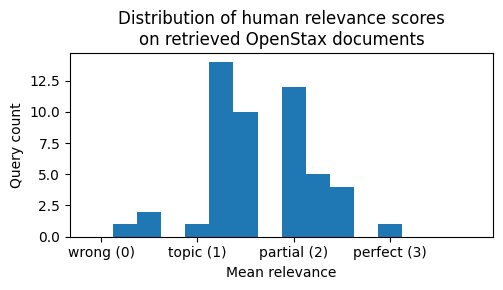

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

bin_width = 0.25
bins = np.arange(0, len(relevance_answers) + bin_width, bin_width)
ax.hist(relevance_df.mean_relevance, bins=bins, align="left")
ax.set_xticks(
    list(range(len(relevance_answers))), labels=[f"{answer} ({i})" for i, answer in enumerate(relevance_answers)]
)

ax.set_xlabel("Mean relevance")
ax.set_ylabel("Query count")
ax.set_title("Distribution of human relevance scores\non retrieved OpenStax documents")

fig.tight_layout()
plt.show()

In [11]:
# create the unannotated faithfulness df


def get_random_text(size: int = 10):
    choices = list(string.ascii_lowercase)
    return " ".join(np.random.choice(choices, size=size))


ds = []
for query in queries:
    for corpus in [math_corpus, recipes_corpus]:
        for guidance in guidance_conditions:
            document = "Retrieved document text\n" + "\n".join([get_random_text() for passage in range(4)])
            generation = (
                "Generated text " + get_random_text()
            )  # TODO do rag here, retrieved a document and generating a response

            for annotator in annotators:
                ds.append(
                    {
                        "generation": generation,
                        "document": document,
                        "guidance": guidance,
                        "faithfulness": "",
                        **corpus,
                        **annotator,
                        **query,
                    }
                )
unannotated_df = pd.DataFrame(ds)
print(len(unannotated_df))
unannotated_df.sample(1)

600


,generation,document,guidance,faithfulness,corpus,annotator,query
570,Generated text n a l m m p q a r y,Retrieved document text\ni v o q h z h b m o\n...,low,,recipes,0,sample query 47


In [255]:
# annotate for faithfulness
faithfulness_df = unannotated_df.copy()
print(faithfulness_answers)


def annotate_faithfulness(row):
    query = row.query
    document = row.document
    generation = row.generation
    guidance = row.guidance
    # this is where a human would use the elements to make an assessment
    if guidance == "low":
        faithfulness = rng.choice(faithfulness_answers, p=(0.2, 0.5, 0.3))
    else:
        faithfulness = rng.choice(faithfulness_answers, p=(0.1, 0.4, 0.5))
    return faithfulness


faithfulness_df["faithfulness"] = faithfulness_df.apply(annotate_faithfulness, axis=1)
faithfulness_df.sample(n=1)

['none', 'partial', 'perfect']


,generation,document,guidance,faithfulness,corpus,annotator,query
7,Generated text,Retrieved document text,low,partial,recipes,1,sample query 0


In [256]:
# do some annotator agreement disambiguation
# we could just take the mean of the level (0, 1, 2)
faithfulness_df["faithfulness_level"] = faithfulness_df.faithfulness.map(lambda f: faithfulness_answers.index(f))
group_keys = ["query", "corpus", "guidance"]
mean_faithfulness = faithfulness_df.groupby(group_keys).faithfulness_level.mean().rename("mean_faithfulness")
faithfulness_df = (
    faithfulness_df.drop_duplicates(subset=group_keys)
    .drop(columns=["annotator", "faithfulness", "faithfulness_level"])
    .join(mean_faithfulness, on=group_keys)
    .reset_index(drop=True)
)
faithfulness_df.sample(n=1)

,generation,document,guidance,corpus,query,mean_faithfulness
196,Generated text,Retrieved document text,low,math,sample query 49,1.333333


In [257]:
# now, merge in relevance to the unannotated_df
# pd.merge(faithfulness_df, relevance_df[["query", "mean_relevance"]], how="left", on=["query", "corpus"])
query_df = faithfulness_df.join(
    relevance_df[["query", "corpus", "mean_relevance"]].set_index(["query", "corpus"]),
    how="left",
    on=["query", "corpus"],
)
# by definition, recipes have no relevance to the queries
query_df.loc[query_df.corpus == "recipes", "mean_relevance"] = 0.0
assert query_df.mean_relevance.isna().sum() == 0
query_df.sort_values(by=["query", "guidance", "corpus"])
query_df.head(n=4)

,generation,document,guidance,corpus,query,mean_faithfulness,mean_relevance
0,Generated text,Retrieved document text,low,math,sample query 0,1.000000,1.0
1,Generated text,Retrieved document text,high,math,sample query 0,1.333333,1.0
2,Generated text,Retrieved document text,low,recipes,sample query 0,1.666667,0.0
3,Generated text,Retrieved document text,high,recipes,sample query 0,1.000000,0.0


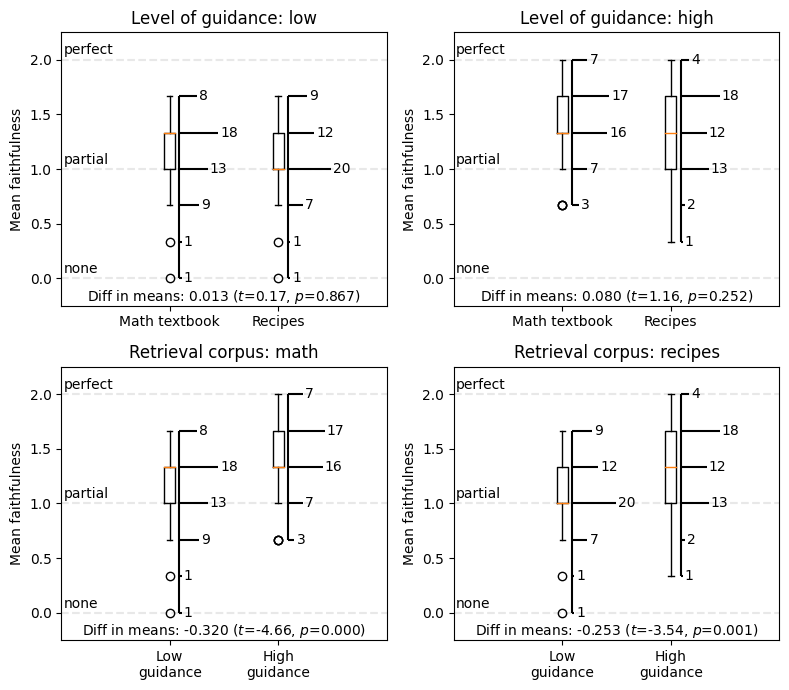

In [259]:
# compare faithfulness distribution between recipes and math corpus
# we hypothesize that faithfulness should be the same or slightly higher for math, but this doesn't really matter
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
axes = axes.reshape(-1)


def plot_faithfulness_comparison(ax, g1, g2, labels, title):
    box_width = 0.1
    ax.boxplot(
        [
            g1,
            g2,
        ],
        widths=box_width,
    )
    ax.set_xticks([1, 2], labels=labels)
    ax.set_ylabel("Mean faithfulness")
    ax.set_title(title)

    # two-sample t-test
    # this complex line of code works, but is not necessary since the dataframe is sorted by query
    # g1, g2 = zip(*query_df.groupby("query").apply(lambda group: (group[group.corpus == "math"].mean_faithfulness.iloc[0], group[group.corpus == "recipes"].mean_faithfulness.iloc[0])))
    g1, g2 = np.array(g1), np.array(g2)
    mean_diff = (g1 - g2).mean()
    t, p = scipy.stats.ttest_rel(g1, g2)
    # ax.text(1.5, min(g1.min(), g2.min()) - 0.05, f"Diff in means: {mean_diff:.3f} ($t$={t:.2f}, $p$={p:.3f})", ha="center", va="top")

    # ax.hist(g1, bins=20, orientation="horizontal", bottom=1, density=True)
    # np.histogram(g1, bins=bins
    for g, x in [(g1, 1), (g2, 2)]:
        xmin = x + (box_width / 2) + 0.04
        ax.vlines(xmin, ymin=g.min(), ymax=g.max(), color="black")
        for value, count in Counter(g).most_common():
            xmax = xmin + (count / len(g))
            ax.hlines(y=value, xmin=xmin, xmax=xmax, color="black")
            ax.text(x=xmax + 0.02, y=value, s=f"{count}", va="center", ha="left")

    ax.set_ylim(bottom=-0.25, top=2.25)
    ax.set_xlim(0, 3)
    ax.text(
        1.5, ax.get_ylim()[0], f"Diff in means: {mean_diff:.3f} ($t$={t:.2f}, $p$={p:.3f})", ha="center", va="bottom"
    )

    for i, answer in enumerate(faithfulness_answers):
        ax.axhline(i, color="lightgray", linestyle="--", alpha=0.5, zorder=-1)
        ax.text(ax.get_xlim()[0] + 0.02, i + 0.02, answer, ha="left", va="bottom")


for ax_ind, guidance in enumerate(["low", "high"]):
    ax = axes[ax_ind]
    labels = ["Math textbook", "Recipes"]
    g1 = query_df[(query_df.corpus == "math") & (query_df.guidance == guidance)].mean_faithfulness
    g2 = query_df[(query_df.corpus == "recipes") & (query_df.guidance == guidance)].mean_faithfulness
    title = f"Level of guidance: {guidance}"
    plot_faithfulness_comparison(ax, g1, g2, labels, title)

for ax_ind, corpus in enumerate(["math", "recipes"]):
    ax = axes[ax_ind + 2]
    labels = ["Low\nguidance", "High\nguidance"]
    g1 = query_df[(query_df.corpus == corpus) & (query_df.guidance == "low")].mean_faithfulness
    g2 = query_df[(query_df.corpus == corpus) & (query_df.guidance == "high")].mean_faithfulness
    title = f"Retrieval corpus: {corpus}"
    plot_faithfulness_comparison(ax, g1, g2, labels, title)

fig.tight_layout()
plt.show()

Level of guidance: low
                            OLS Regression Results                            
Dep. Variable:      mean_faithfulness   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.035
Date:                Thu, 31 Aug 2023   Prob (F-statistic):              0.314
Time:                        14:34:59   Log-Likelihood:                -21.654
No. Observations:                  50   AIC:                             47.31
Df Residuals:                      48   BIC:                             51.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.

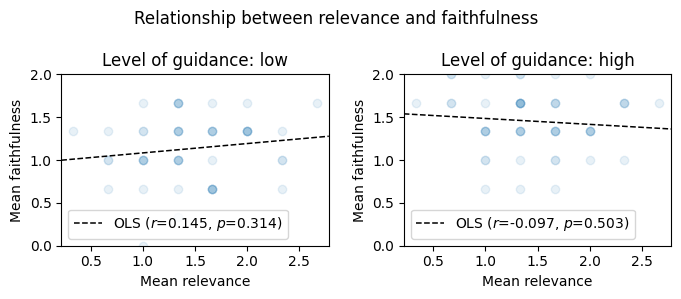

In [265]:
# explore correlation between relevance and faithfulness in the math corpus
# we would expect a small positive correlation
# when guidance is high, we expect a stronger correlation
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes = axes.reshape(-1)


def plot_relevance_vs_faithfulness(ax, sdf, title="", ylim=None):
    # correlation
    r, p = scipy.stats.pearsonr(sdf.mean_relevance, sdf.mean_faithfulness)
    # and the approximately equivalent linear regression
    # https://sebastianraschka.com/faq/docs/pearson-r-vs-linear-regr.html
    model = sm.OLS.from_formula(formula="mean_faithfulness ~ mean_relevance", data=sdf)
    model = model.fit()
    params = model.params

    # ax.hist2d(sdf.mean_relevance, sdf.mean_faithfulness, cmin=1)
    ax.scatter(sdf.mean_relevance, sdf.mean_faithfulness, alpha=0.1, marker="o")
    ax.set_xlabel("Mean relevance")
    ax.set_ylabel("Mean faithfulness")
    ax.set_title(title)

    if ylim:
        ax.set_ylim(ylim)

    statsmodels.graphics.regressionplots.abline_plot(
        model_results=model,
        ax=ax,
        color="black",
        linestyle="--",
        linewidth=1.1,
        label=f"OLS ($r$={r:.3f}, $p$={p:.3f})",
    )
    ax.legend()
    print(title)
    print(model.summary())


for ax_ind, guidance in enumerate(guidance_conditions):
    ax = axes[ax_ind]
    sdf = query_df[(query_df.corpus == "math") & (query_df.guidance == guidance)]
    title = f"Level of guidance: {guidance}"
    plot_relevance_vs_faithfulness(ax, sdf, title, ylim=(0, 2))

fig.suptitle("Relationship between relevance and faithfulness")

fig.tight_layout()
plt.show()

In [ ]:
# now create pairwise surveys
# most important: math/low vs math/high correctness

In [ ]:
# TODO could look for correlations here between automated metrics (like % of word overlap, and other more complex groundedness metrics)
# and human annotations of faithfulness

In [23]:
passages = ["Test text with extra."]
generation = "test text with extra words."
experiment_utils.metrics.compute_macro_f1(passages, generation)

0.9090909090909091

In [7]:
# create automated metric df


def get_random_text(size: int = 10):
    choices = list(string.ascii_lowercase)
    return " ".join(np.random.choice(choices, size=size))


corpus = math_corpus
ds = []
for query in queries:
    for guidance in ["A", "B", "C", "D", "E", "F"]:
        document = "Retrieved document text\n" + "\n".join([get_random_text() for passage in range(4)])
        generation = (
            "Generated text " + get_random_text()
        )  # TODO do rag here, retrieved a document and generating a response
        if guidance == "F":
            document += " a a a a a b b b b"
            generation += " a a a a a b b b b"
        ds.append({"generation": generation, "document": document, "guidance": guidance, **corpus, **query})
math_df = pd.DataFrame(ds)
print(len(math_df))
math_df.sample(1)

300


,generation,document,guidance,corpus,query
154,Generated text e a f c p f r z g k,Retrieved document text\nt n h r j c m c f x\n...,E,math,sample query 25


In [10]:
sdf = math_df[math_df.corpus == "math"]
# sdf = sdf.drop_duplicates(subset=["query", "generation", "document", "guidance"])
ds = []
for guidance, group in sdf.groupby("guidance"):
    assert group["query"].nunique() == len(group)
    f1_scores = []
    for row in group.itertuples():
        passages = document.split("\n")
        f1 = experiment.metrics.compute_macro_f1(passages, row.generation)
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    macro_f1 = f1_scores.mean()
    # bootstrap confidence intervals
    bootstrap = scipy.stats.bootstrap((f1_scores,), np.mean, confidence_level=0.95, random_state=rng)
    ds.append(
        {
            "guidance": guidance,
            "macro_f1": macro_f1,
            "macro_f1_low": bootstrap.confidence_interval.low,
            "macro_f1_high": bootstrap.confidence_interval.high,
        }
    )
f1_df = pd.DataFrame(ds).sort_values(by="macro_f1", ascending=True)
f1_df

,guidance,macro_f1,macro_f1_low,macro_f1_high
3,D,0.421927,0.404139,0.441069
0,A,0.438886,0.415790,0.464270
1,B,0.439605,0.416518,0.462711
4,E,0.445563,0.420524,0.469068
2,C,0.455749,0.435010,0.476656
5,F,0.464326,0.439977,0.487834


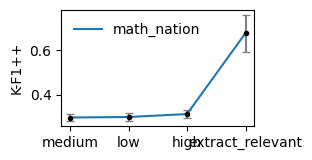

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3.2, 1.7))

metric = "macro_f1"
# copy = f1_df.copy()
# copy[[metric, metric + "_low", metric + "_high"]] += 0.1
# for query_set, metric_df in [("MN Geo", f1_df), ("MN PreA", copy)]:
for query_set, metric_df in f1_df.groupby("query_set"):
    assert metric in metric_df.columns
    xs = list(range(len(metric_df)))
    ys = metric_df[metric]
    yerr = metric_df[[metric + "_low", metric + "_high"]].subtract(metric_df[metric], axis=0).abs().T
    ax.scatter(xs, ys, color="black", marker=".")
    ax.errorbar(xs, ys, yerr=yerr, zorder=-1, capsize=3, ecolor="grey", label=query_set)

# legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, frameon=False, ncol=2)


ax.set_xticks(xs, labels=f1_df.guidance)
ax.set_ylabel("K-F1++")
# ax.set_ylim((0.2, 0.35))  # Consider manually setting the ylim

fig.tight_layout()
plt.show()

## Real data

#### Load query data

In [10]:
mn_general_student_queries_filepath = data_dir / "derived" / "mn_general_student_queries.csv"
query_df = pd.read_csv(mn_general_student_queries_filepath)
student_queries = [
    row.post_content.strip().replace("[Continued:]", "\n")
    for row in query_df.sample(frac=1, random_state=87896).itertuples()
    if row.is_respondable_query == "general"
]
len(student_queries)

51

In [11]:
query_df.subject_name.value_counts()

subject_name
Algebra 1      43
Geometry        9
Pre-Algebra     3
Name: count, dtype: int64

#### Retrieve documents

In [12]:
embedding_dir = data_dir / "derived" / "embeddings"
rori_db = retrieval.RetrievalDb(embedding_dir, "rori_microlesson", "db_string")
openstax_db = retrieval.RetrievalDb(embedding_dir, "openstax_subsection", "db_string")
recipe_db = retrieval.RetrievalDb(embedding_dir, "recipenlg", "db_string")

In [13]:
openstax_db.df.n_tokens.median()

185.0

In [14]:
openstax_db.df.groupby("chapter").n_tokens.sum().median()

5050.0

In [12]:
# create generations
openstax_subsection_db_info = retrieval.DbInfo(
    openstax_db,
    max_tokens=3000,
    max_texts=1,
    prefix="",
    use_parent_text=True,
    parent_group_cols=["chapter", "section"],
    parent_sort_cols=["index"],
)
openstax_retrieval_strategy = retrieval_strategies.MappedEmbeddingRetrievalStrategy(
    {
        "openstax_subsection_texts": openstax_subsection_db_info,
    },
)

corpus = math_corpus
ds = []
for query in student_queries:
    for guidance in experiment.guidance_conditions.guidance_condition_name_list:
        # TODO consider adding infrastructure to cache the messages and document
        prompt_manager = prompt_utils.PromptManager()
        prompt_manager.set_intro_messages(experiment.guidance_conditions.guidance_condition_messages_map[guidance])
        prompt_manager.set_retrieval_strategy(openstax_retrieval_strategy)
        messages = prompt_manager.build_query(query)
        document = prompt_manager.get_recent_slot_fill("openstax_subsection_texts")
        # assert document is not None, f"Couldn't find expected key in {prompt_manager.recent_slot_fill_dict}."
        ds.append(
            {
                "query_set": "math_nation",
                "query": query,
                "generation": "",
                "document": document,
                "guidance": guidance,
                "messages": messages,
                **corpus,
            }
        )
math_df = pd.DataFrame(ds)
print(len(math_df))
math_df.sample(1)

204


,query_set,query,generation,document,guidance,messages,corpus
149,math_nation,I know that this has been a consistent questio...,,Identify the Intercepts on a Graph: Every line...,low,"[{'role': 'system', 'content': 'You are going ...",math


In [13]:
# fill documents for the None retrieval condition
documents = (
    math_df.loc[math_df.document.notna(), ["query", "corpus", "document"]]
    .drop_duplicates(keep="first")
    .set_index("query")
)
math_df.loc[math_df.document.isna(), "document"] = list(
    documents.loc[math_df.loc[math_df.document.isna(), "query"]].document
)
assert math_df.document.isna().sum() == 0

#### Create or load relevance annotation for queries

In [12]:
query_df = math_df[(math_df.query_set == "math_nation") & (math_df.corpus == "math") & (math_df.guidance == "low")]
assert query_df["query"].nunique() == len(query_df)
query_df.sample(n=1)

NameError: name 'math_df' is not defined

In [15]:
relevance_data_dir = data_dir / "derived" / "relevance"
relevance_data_dir.mkdir(exist_ok=True)
mn_relevance_filepath_1 = relevance_data_dir / "mn_set1_relevance.csv"
mn_relevance_filepath_1_filled = relevance_data_dir / "mn_set1_relevance_filled.csv"

In [16]:
# create relevance annotation spreadsheet
if not mn_relevance_filepath_1_filled.exists():
    query_df = query_df[["query_set", "corpus", "query", "document"]].reset_index(drop=True).sample(frac=1)
    query_df["relevance"] = ""

    def make_document_more_readable(doc):
        passages = doc.split("\n")
        return " - " + "\n - ".join(passages)

    query_df["document"] = query_df["document"].map(make_document_more_readable)
    query_df.to_csv(mn_relevance_filepath_1, index=False)
query_df.sample(n=1)

,post_id,subject_name,post_content,is_respondable_query
14,1140336,Algebra 1,how do i solve square root functions,general


In [126]:
# load relevance_df
if mn_relevance_filepath_1_filled.exists():
    relevance_df = pd.read_csv(mn_relevance_filepath_1_filled)
relevance_df.sample(n=1)

,query_set,corpus,query,document,Zach,Chenglu,Wangda
11,math_nation,math,after you distribute a negative does it disapp...,- Model Subtraction of Integers: Remember the...,Partial,Partial,Partial


In [127]:
def get_numeric_relevance(relevance_str):
    if pd.isna(relevance_str):
        return np.nan
    return relevance_answers.index(relevance_str.lower())


for annotator_name in ["Zach", "Chenglu", "Wangda"]:
    relevance_df[annotator_name].map(get_numeric_relevance)
    print(relevance_df[annotator_name].value_counts(dropna=False))

Zach
Topic      23
Perfect    10
Partial     9
Wrong       9
Name: count, dtype: int64
Chenglu
Partial    14
Perfect    14
Topic      13
Wrong      10
Name: count, dtype: int64
Wangda
Wrong      17
Topic      15
Partial    13
Perfect     6
Name: count, dtype: int64


In [19]:
relevance_annotators = ["Zach", "Chenglu", "Wangda"]
for a1, a2 in itertools.combinations(relevance_annotators, 2):
    acc = (relevance_df[a1] == relevance_df[a2]).sum() / len(relevance_df)
    print(f"{a1}-{a2} agreement: {acc:.2%}")
a1, a2, a3 = relevance_annotators
all_equal = (relevance_df[a1] == relevance_df[a2]) & (relevance_df[a2] == relevance_df[a3])
print(f"All agreement: {all_equal.sum() / len(relevance_df):.2%}")

Zach-Chenglu agreement: 35.29%
Zach-Wangda agreement: 37.25%
Chenglu-Wangda agreement: 35.29%
All agreement: 15.69%


In [20]:
reliability_data = [relevance_df[annotator].map(get_numeric_relevance) for annotator in relevance_annotators]
krippendorff.alpha(reliability_data=reliability_data, level_of_measurement="ordinal")

0.40203749880846007

In [21]:
relevance_data = np.array([relevance_df[annotator].map(get_numeric_relevance) for annotator in relevance_annotators])
relevance_data.shape

(3, 51)

In [22]:
# data containing category assignment with subjects in rows and raters in columns
arr, categories = statsmodels.stats.inter_rater.aggregate_raters(relevance_data.T, n_cat=len(relevance_answers))
statsmodels.stats.inter_rater.fleiss_kappa(arr, method="fleiss")

0.13409563409563408

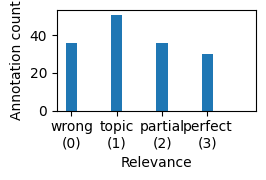

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 1.9))

xs = relevance_data.reshape(-1)

bin_width = 0.25
bins = np.arange(0, len(relevance_answers) + bin_width, bin_width)
ax.hist(xs, bins=bins, align="left")
ax.set_xticks(
    list(range(len(relevance_answers))), labels=[f"{answer}\n({i})" for i, answer in enumerate(relevance_answers)]
)

ax.set_xlabel("Relevance")
ax.set_ylabel("Annotation count")

fig.tight_layout()
plt.show()

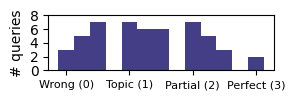

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 0.8))

xs = relevance_data.T.mean(axis=1)

bin_width = 0.25
bins = np.arange(0, len(relevance_answers) - (bin_width * 2), bin_width)
ax.hist(xs, bins=bins, align="left", color=matplotlib.cm.viridis(0.18))
ax.set_xticks(
    list(range(len(relevance_answers))),
    labels=[f"{answer.capitalize()} ({i})" for i, answer in enumerate(relevance_answers)],
    fontsize=8,
)
ax.set_yticks([0, 2, 4, 6, 8])

# ax.set_xlabel("Mean relevance")
ax.set_ylabel("# queries")

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "mean_relevance2.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
plt.show()

In [25]:
mean_relevance = relevance_data.T.mean(axis=1)
(mean_relevance >= 1).sum() / len(mean_relevance), (mean_relevance >= 2).sum() / len(mean_relevance)

(0.7058823529411765, 0.3333333333333333)

In [26]:
# make relevance_df numeric
relevance_df.loc[:, ["Chenglu", "Zach", "Wangda"]] = relevance_df[["Chenglu", "Zach", "Wangda"]].map(
    get_numeric_relevance
)

In [27]:
# create mean_relevance_series
mean_relevance_series = (
    relevance_df.groupby("query")[["Chenglu", "Zach", "Wangda"]].apply(np.mean).rename("mean_relevance")
)
mean_relevance_series.median(), mean_relevance_series.mean()

(1.3333333333333333, 1.3921568627450978)

#### Create or load generations

In [15]:
corpus = experiment.generate.GenerationCorpus(data_dir / "derived", "math_corpus_test")
metadata_list = [row.to_dict() for _, row in math_df.iterrows()]
len(corpus.generations)

255

In [16]:
assert corpus.filter_generations() == 0

In [17]:
# conditionally remove
# corpus.filter_generations(should_remove_func=lambda generation: generation["guidance"] == "high")

In [17]:
len(corpus.generations)

255

In [18]:
nonmatching_generations = corpus.get_nonmatching_generations(metadata_list)
obsolete_df = pd.DataFrame(nonmatching_generations)
len(obsolete_df)

0

In [19]:
print(obsolete_df[["query_set", "query", "generation", "document", "guidance", "corpus"]].nunique())
obsolete_df.guidance.value_counts()

KeyError: "None of [Index(['query_set', 'query', 'generation', 'document', 'guidance', 'corpus'], dtype='object')] are in the [columns]"

In [ ]:
# remove non-matching from the generations list
_ = corpus.get_nonmatching_generations(metadata_list, should_remove_nonmatching=True)
len(corpus.generations)

In [23]:
# optionally, overwrite to forget deleted generations
corpus.overwrite()

In [20]:
# limiting factor is tokens per minute
# https://platform.openai.com/docs/guides/rate-limits/overview
max_tokens_per_minute = 90000

request_tokens = 4000
n_processes = 8
sleep_time = 16
request_time = 4 + sleep_time
process_tokens_per_minute = (request_tokens / request_time) * 60
tokens_per_minute = process_tokens_per_minute * n_processes
tokens_per_minute, tokens_per_minute / request_tokens  # approximate requests per minute

(96000.0, 24.0)

In [21]:
len(corpus.batch_filter_not_already_generated(metadata_list)), len(metadata_list)

(0, 204)

In [22]:
n_generated = corpus.batch_generate(
    metadata_list,
    n_processes=8,
    sleep=16.0,
    should_log_successful=True,
    request_timeout=40,
)
n_generated, len(corpus.generations)

(0, 255)

In [23]:
math_df = pd.DataFrame(corpus.generations)
print(len(math_df))
math_df = math_df.drop_duplicates(subset=["query_set", "query", "guidance", "corpus"], keep="last")
print(len(math_df))
math_df.sample(n=1)

255
204


,query_set,query,generation,document,guidance,messages,corpus
126,math_nation,what is the difference between communtative pr...,"According to the student's question, the most ...",Use the Commutative and Associative Properties...,extract_relevant,"[{'role': 'user', 'content': 'Given a middle-s...",math


In [24]:
math_df.guidance.value_counts()

guidance
low                 51
extract_relevant    51
none                51
high                51
Name: count, dtype: int64

In [25]:
verbose = False
if verbose:
    query_sample = np.random.choice(list(set(math_df["query"])), size=4, replace=False)
    for query, group in math_df[math_df["query"].isin(query_sample)].groupby("query"):
        print(f"=== {query} ===")
        print(group.iloc[0].document)
        for row in group.itertuples():
            print(f"+++ {row.guidance} +++")
            print(row.generation)
            print()
        print()

#### Save math_df

In [40]:
math_df.sample(n=1)

,query_set,query,generation,document,guidance,messages,corpus
187,math_nation,How do you find the zeros of a function by gra...,"To find the zeros of a function by graphing, y...",Plot Points on a Rectangular Coordinate System...,none,"[{'role': 'system', 'content': 'You are going ...",math


In [41]:
generations_dir = data_dir / "derived" / "generations"
generations_dir.mkdir(exist_ok=True)
math_df.to_csv(generations_dir / "math_df.csv", index=False)

#### Compute automated metrics

In [12]:
# load the data, if previously cached
generations_dir = data_dir / "derived" / "generations"
math_df = pd.read_csv(generations_dir / "math_df.csv")
math_df.sample(n=1)

,query_set,query,generation,document,guidance,messages,corpus
46,math_nation,How do you find the domain and range that are ...,"To find the domain and range for a function, w...",Use Division Notation: So far we have explored...,low,"[{'role': 'system', 'content': 'You are going ...",math


In [13]:
assert experiment.metrics.get_bleurt_metric_object() is not None
assert experiment.metrics.get_bertscore_metric_object() is not None

2023-12-08 17:59:32,299 - evaluate_modules.metrics.evaluate-metric--bleurt.98e148b2f8c4a88aba5037e4e0e90c9fd9ec35dc37a054ded8cfef0fa801ffab.bleurt - WARNING - Using default BLEURT-Base checkpoint for sequence maximum length 128. You can use a bigger model for better results with e.g.: evaluate.load('bleurt', 'bleurt-large-512').


INFO:tensorflow:Reading checkpoint /Users/zacharylevonian/.cache/huggingface/metrics/bleurt/default/downloads/extracted/c344adb923f0c495f61e1f40865ccb4ce783ec9297c810bb96017735fbae8a91/bleurt-base-128.


2023-12-08 17:59:32,674 - tensorflow - INFO - Reading checkpoint /Users/zacharylevonian/.cache/huggingface/metrics/bleurt/default/downloads/extracted/c344adb923f0c495f61e1f40865ccb4ce783ec9297c810bb96017735fbae8a91/bleurt-base-128.


INFO:tensorflow:Config file found, reading.


2023-12-08 17:59:32,674 - tensorflow - INFO - Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


2023-12-08 17:59:32,675 - tensorflow - INFO - Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


2023-12-08 17:59:32,676 - tensorflow - INFO - Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


2023-12-08 17:59:32,676 - tensorflow - INFO - ... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


2023-12-08 17:59:32,677 - tensorflow - INFO - ... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


2023-12-08 17:59:32,677 - tensorflow - INFO - ... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


2023-12-08 17:59:32,678 - tensorflow - INFO - ... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


2023-12-08 17:59:32,678 - tensorflow - INFO - ... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


2023-12-08 17:59:32,678 - tensorflow - INFO - Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


2023-12-08 17:59:32,679 - tensorflow - INFO - Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


2023-12-08 17:59:32,717 - tensorflow - INFO - WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


2023-12-08 17:59:32,718 - tensorflow - INFO - Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


2023-12-08 17:59:32,719 - tensorflow - INFO - Loading model.
2023-12-08 17:59:33,949 - absl - INFO - Fingerprint not found. Saved model loading will continue.


INFO:tensorflow:BLEURT initialized.


2023-12-08 17:59:33,952 - tensorflow - INFO - BLEURT initialized.


In [14]:
sdf = math_df
assert sdf.query_set.nunique() == 1
ds = []
for row in tqdm(sdf.itertuples(), total=len(sdf)):
    passages = row.document.split("\n")
    f1 = experiment.metrics.compute_macro_f1(passages, row.generation, discount_text=row.query)
    bleurt = experiment.metrics.compute_bleurt(passages, row.generation)
    bertscore = experiment.metrics.compute_bertscore(passages, row.generation)
    ds.append(
        {
            **row._asdict(),
            "f1": f1,
            "bleurt": bleurt,
            "bertscore": bertscore,
        }
    )
autometric_df = pd.DataFrame(ds)
autometric_df.head(1)

  0%|                                                                                                    | 0/204 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████████████| 204/204 [05:51<00:00,  1.72s/it]


,Index,query_set,query,generation,document,guidance,messages,corpus,f1,bleurt,bertscore
0,0,math_nation,Can I get the steps for factoring quadratics,Of course! Factoring quadratics can be done us...,Find the Greatest Common Factor of Two or More...,low,"[{'role': 'system', 'content': 'You are going ...",math,0.362694,-0.785839,0.837763


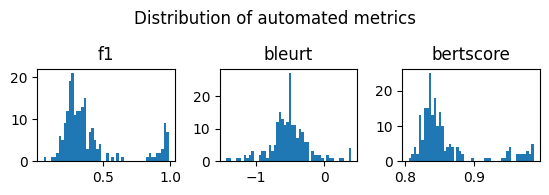

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(COLUMN_WIDTH_IN, 1.9))
mdf = autometric_df
for ax, metric in zip(axes, ["f1", "bleurt", "bertscore"]):
    assert metric in mdf.columns
    ax.hist(mdf[metric], bins=50)
    ax.set_title(metric)

fig.suptitle("Distribution of automated metrics")
fig.tight_layout(pad=0.8)
plt.show()

In [16]:
use_bootstrap = False

ds = []
for guidance, group in autometric_df.groupby("guidance"):
    assert group["query"].nunique() == len(group)
    if use_bootstrap:
        # bootstrap confidence intervals
        bootstrap = scipy.stats.bootstrap((group.f1,), np.mean, confidence_level=0.95, random_state=rng)
        f1_low, f1_high = bootstrap.confidence_interval.low, bootstrap.confidence_interval.high
        bleurt_bootstrap = scipy.stats.bootstrap((group.bleurt,), np.mean, confidence_level=0.95, random_state=rng)
        bleurt_low, bleurt_high = bleurt_bootstrap.confidence_interval.low, bleurt_bootstrap.confidence_interval.high
        bertscore_bootstrap = scipy.stats.bootstrap(
            (group.bertscore,), np.mean, confidence_level=0.95, random_state=rng
        )
        bertscore_low, bertscore_high = (
            bertscore_bootstrap.confidence_interval.low,
            bertscore_bootstrap.confidence_interval.high,
        )
    else:
        f1_low, f1_high = statsmodels.stats.weightstats.zconfint(group.f1, alpha=0.05)
        bleurt_low, bleurt_high = statsmodels.stats.weightstats.zconfint(group.bleurt, alpha=0.05)
        bertscore_low, bertscore_high = statsmodels.stats.weightstats.zconfint(group.bertscore, alpha=0.05)
    ds.append(
        {
            "guidance": guidance,
            "query_set": group.iloc[0].query_set,
            "macro_f1": group.f1.mean(),
            "macro_f1_low": f1_low,
            "macro_f1_high": f1_high,
            "bleurt": group.bleurt.mean(),
            "bleurt_low": bleurt_low,
            "bleurt_high": bleurt_high,
            "bertscore": group.bertscore.mean(),
            "bertscore_low": bertscore_low,
            "bertscore_high": bertscore_high,
        }
    )
metric_df = pd.DataFrame(ds).sort_values(by="macro_f1", ascending=True)
metric_df

,guidance,query_set,macro_f1,macro_f1_low,macro_f1_high,bleurt,bleurt_low,bleurt_high,bertscore,bertscore_low,bertscore_high
3,none,math_nation,0.270858,0.254724,0.286991,-0.571418,-0.619313,-0.523524,0.833604,0.830900,0.836308
2,low,math_nation,0.287759,0.269676,0.305841,-0.551136,-0.601682,-0.500591,0.836041,0.833053,0.839030
1,high,math_nation,0.355556,0.333788,0.377324,-0.464588,-0.522172,-0.407004,0.848303,0.844029,0.852577
0,extract_relevant,math_nation,0.672882,0.585646,0.760118,-0.480035,-0.612709,-0.347361,0.919087,0.903411,0.934763


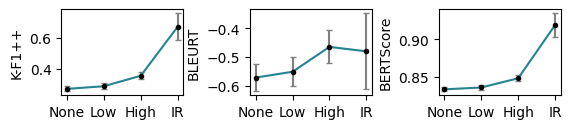

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(COLUMN_WIDTH_IN, 1.1))

metric_pretty_name_map = {
    "macro_f1": "K-F1++",
    "bleurt": "BLEURT",
    "bertscore": "BERTScore",
}

guidance_short_name_map = {
    "none": "None",
    "extract_relevant": "IR",
    "low": "Low",
    "medium": "M",
    "high": "High",
}

for ax, metric in zip(axes, ["macro_f1", "bleurt", "bertscore"]):
    for query_set, mdf in metric_df.groupby("query_set"):
        assert metric in mdf.columns
        xs = list(range(len(mdf)))
        ys = mdf[metric]
        yerr = mdf[[metric + "_low", metric + "_high"]].subtract(mdf[metric], axis=0).abs().T
        ax.scatter(xs, ys, color="black", marker=".")
        ax.errorbar(
            xs, ys, yerr=yerr, zorder=-1, capsize=2, ecolor="gray", color=matplotlib.cm.viridis(0.45), label=query_set
        )

    # legend
    # handles, labels = ax.get_legend_handles_labels()
    # handles = [h[0] for h in handles]
    # ax.legend(handles, labels, frameon=False, ncol=2)

    ax.set_xticks(xs, labels=[guidance_short_name_map[guidance] for guidance in metric_df.guidance])
    ax.set_ylabel(metric_pretty_name_map[metric])

fig.tight_layout(pad=0.01, w_pad=0.2)
# fig.savefig(figures_dir / "guidance_autometrics.pdf", bbox_inches="tight", pad_inches=0.01, dpi=DPI)
plt.show()

In [27]:
autometric_df

,Index,query_set,query,generation,document,guidance,messages,corpus,f1,bleurt,bertscore
0,0,math_nation,Can I get the steps for factoring quadratics,Of course! Factoring quadratics can be done us...,Find the Greatest Common Factor of Two or More...,low,"[{'role': 'system', 'content': 'You are going ...",math,0.362694,-0.785839,0.837763
1,1,math_nation,I need a standard way of recognizing polynomia...,Of course! I'd be happy to help you recognize ...,"Identify Polynomials, Monomials, Binomials, an...",low,"[{'role': 'system', 'content': ""You are going ...",math,0.465409,-0.560453,0.842730
2,2,math_nation,how do i solve square root functions,"To solve square root functions, follow these s...",Simplify Expressions with Square Roots: To sta...,low,"[{'role': 'system', 'content': 'You are going ...",math,0.273504,-0.516538,0.830718
3,3,math_nation,Can someone explain like interior and exterior...,Of course! I'd be happy to explain interior an...,Use the Properties of Angles: Are you familiar...,low,"[{'role': 'system', 'content': 'You are going ...",math,0.362319,-0.657461,0.837373
4,4,math_nation,How do you find the radius?,"To find the radius of a circle, you need to kn...","Convert Fractions to Decimals: In Decimals, we...",low,"[{'role': 'system', 'content': 'You are going ...",math,0.250000,-0.257543,0.834398
...,...,...,...,...,...,...,...,...,...,...,...
199,199,math_nation,How do you find the domain and range that are ...,To find the domain and range of a certain func...,Use Division Notation: So far we have explored...,high,"[{'role': 'system', 'content': 'You are going ...",math,0.252874,-0.429044,0.816907
200,200,math_nation,Is a rational and irrational number always irr...,A rational number is a number that can be writ...,Identify Rational Numbers and Irrational Numbe...,high,"[{'role': 'system', 'content': 'You are going ...",math,0.274648,-0.549916,0.846885
201,201,math_nation,what is the quadratic formula?,The quadratic formula is a formula that allows...,Simplify Expressions with Square Roots: To sta...,high,"[{'role': 'system', 'content': 'You are going ...",math,0.294118,-0.459381,0.831446
202,202,math_nation,i need help on how to graph quadratic funtions,"To graph quadratic functions, we can use a sim...",Recognize the Relation Between the Solutions o...,high,"[{'role': 'system', 'content': 'You are going ...",math,0.401674,-0.268822,0.852153


normal median: -0.517; median<0: -0.517


177    0.075259
185    0.055574
Name: bleurt, dtype: float64

none median: -0.565; median<0: -0.565


Series([], Name: bleurt, dtype: float64)

low median: -0.551; median<0: -0.551


Series([], Name: bleurt, dtype: float64)

high median: -0.463; median<0: -0.468


177    0.075259
185    0.055574
Name: bleurt, dtype: float64

extract_relevant median: -0.486; median<0: -0.564


70    0.398484
66    0.397741
85    0.378764
Name: bleurt, dtype: float64

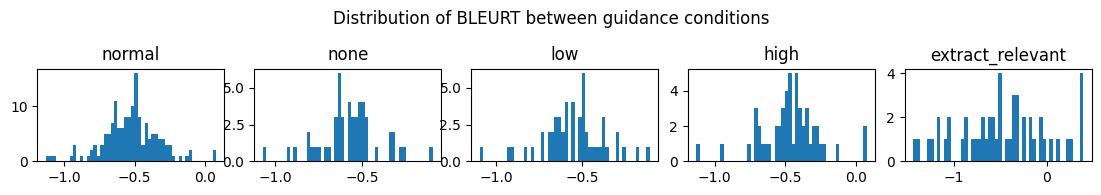

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(COLUMN_WIDTH_IN * 2, 1.9))
for ax, group_name in zip(axes, ["normal", "none", "low", "high", "extract_relevant"]):
    if group_name == "normal":
        mdf = autometric_df[autometric_df.guidance != "extract_relevant"]
    else:
        mdf = autometric_df[autometric_df.guidance == group_name]
    ax.hist(mdf["bleurt"], bins=50, log=False)
    ax.set_title(group_name)
    print(f"{group_name} median: {mdf.bleurt.median():.3f}; median<0: {mdf[mdf.bleurt < 0].bleurt.median():.3f}")
    display(mdf[mdf.bleurt > 0].bleurt.sort_values(ascending=False).head(3))

fig.suptitle("Distribution of BLEURT between guidance conditions")
fig.tight_layout(pad=0.8)
plt.show()

In [34]:
# merge in relevance
autometric_relevance_df = autometric_df.merge(mean_relevance_series, on="query")
autometric_relevance_df.head(1)

,Index,query_set,query,generation,document,guidance,messages,corpus,f1,bleurt,bertscore,mean_relevance
0,0,math_nation,Can I get the steps for factoring quadratics,Of course! Factoring quadratics can be done us...,Find the Greatest Common Factor of Two or More...,low,"[{'role': 'system', 'content': 'You are going ...",math,0.362694,-0.785839,0.837763,2.0


In [35]:
for guidance in ["none", "low", "high", "all"]:
    for metric in ["f1", "bleurt", "bertscore"]:
        if guidance == "all":
            sdf = autometric_relevance_df
        else:
            sdf = autometric_relevance_df[autometric_relevance_df.guidance == guidance]
        r, p = scipy.stats.pearsonr(sdf[metric], sdf.mean_relevance)
        print(f"{metric=} {guidance=} n={len(sdf)} r={r:.4f} (p={p:.4f}, p_bonf.={p*9:.4f})")

metric='f1' guidance='none' n=51 r=0.2574 (p=0.0682, p_bonf.=0.6137)
metric='bleurt' guidance='none' n=51 r=0.3439 (p=0.0135, p_bonf.=0.1212)
metric='bertscore' guidance='none' n=51 r=0.4303 (p=0.0016, p_bonf.=0.0146)
metric='f1' guidance='low' n=51 r=0.4270 (p=0.0018, p_bonf.=0.0160)
metric='bleurt' guidance='low' n=51 r=0.3407 (p=0.0144, p_bonf.=0.1298)
metric='bertscore' guidance='low' n=51 r=0.5014 (p=0.0002, p_bonf.=0.0016)
metric='f1' guidance='high' n=51 r=0.3710 (p=0.0074, p_bonf.=0.0663)
metric='bleurt' guidance='high' n=51 r=0.2551 (p=0.0708, p_bonf.=0.6371)
metric='bertscore' guidance='high' n=51 r=0.4952 (p=0.0002, p_bonf.=0.0020)
metric='f1' guidance='all' n=204 r=0.0147 (p=0.8351, p_bonf.=7.5162)
metric='bleurt' guidance='all' n=204 r=0.0961 (p=0.1713, p_bonf.=1.5420)
metric='bertscore' guidance='all' n=204 r=0.0278 (p=0.6929, p_bonf.=6.2358)


#### Create qualtrics surveys

In [16]:
guidance_survey_set = {"none", "low", "high"}
survey_input_df = math_df[
    (math_df.query_set == "math_nation") & (math_df.corpus == "math") & (math_df.guidance.isin(guidance_survey_set))
]
len(survey_input_df)

153

In [17]:
qualtrics_template_filepath = data_dir / "raw" / "qualtrics" / "Rori_ranking_annotations_-_template.qsf"
survey_dir = data_dir / "derived" / "qualtrics"
assert qualtrics_template_filepath.exists()

In [18]:
template_survey_text = experiment.qualtrics.get_template(qualtrics_template_filepath)
survey_df = experiment.qualtrics.create_surveys(survey_input_df, template_survey_text, survey_dir)
len(survey_df)

51

In [19]:
survey_df.sample(n=1)

,query,document,response1,response2,response3,response1_meta,response2_meta,response3_meta,survey_id
11,I'm still a little lost on how you find midpoi...,Plot Points on a Rectangular Coordinate System...,"To find the midpoint on a graph, you need to f...",Finding the midpoint on a graph involves findi...,Finding the midpoint on a graph is actually qu...,"{'query_set': 'math_nation', 'guidance': 'high...","{'query_set': 'math_nation', 'guidance': 'low'...","{'query_set': 'math_nation', 'guidance': 'none...",s_20230921_1/4


In [20]:
survey_df.survey_id.value_counts()

survey_id
s_20230921_1/4    15
s_20230921_2/4    15
s_20230921_3/4    15
s_20230921_4/4     6
Name: count, dtype: int64

In [21]:
survey_df.head(3)

,query,document,response1,response2,response3,response1_meta,response2_meta,response3_meta,survey_id
0,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...","Vertex form, also known as completed square fo...",Vertex form is a specific form of writing quad...,Vertex form is a way to write the equation of ...,"{'query_set': 'math_nation', 'guidance': 'none...","{'query_set': 'math_nation', 'guidance': 'high...","{'query_set': 'math_nation', 'guidance': 'low'...",s_20230921_1/4
1,how far can a polynomial go,"Identify Polynomials, Monomials, Binomials, an...",A polynomial can go as far as we want it to go...,"Polynomials can have different degrees, which ...","A polynomial can go on indefinitely, meaning i...","{'query_set': 'math_nation', 'guidance': 'high...","{'query_set': 'math_nation', 'guidance': 'low'...","{'query_set': 'math_nation', 'guidance': 'none...",s_20230921_1/4
2,What is a function notation?,Use Addition Notation: A college student has a...,Function notation is a way to represent the re...,Function notation is a way to represent a math...,Function notation is a way to represent mathem...,"{'query_set': 'math_nation', 'guidance': 'none...","{'query_set': 'math_nation', 'guidance': 'low'...","{'query_set': 'math_nation', 'guidance': 'high...",s_20230921_1/4


In [22]:
survey_df.to_csv(survey_dir / "survey_df.csv", index=False)

#### Analyze survey results

In [36]:
survey_input_dir = data_dir / "derived" / "qualtrics"
survey_results_dir = data_dir / "raw" / "qualtrics" / "results"
assert survey_results_dir.exists()

In [37]:
survey_df = pd.read_csv(survey_input_dir / "survey_df.csv")
survey_df.head(1)

,query,document,response1,response2,response3,response1_meta,response2_meta,response3_meta,survey_id
0,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...","Vertex form, also known as completed square fo...",Vertex form is a specific form of writing quad...,Vertex form is a way to write the equation of ...,"{'query_set': 'math_nation', 'guidance': 'none...","{'query_set': 'math_nation', 'guidance': 'high...","{'query_set': 'math_nation', 'guidance': 'low'...",s_20230921_1/4


In [38]:
ds = []
response_cols = ["response1", "response2", "response3"]
for _, row in survey_df.iterrows():
    d = row.to_dict()
    for col in response_cols:
        d = row.to_dict()
        d["generation"] = d[col]
        for key, value in eval(d[col + "_meta"]).items():
            d[key] = value
        for col in response_cols:
            del d[col]
            del d[col + "_meta"]
        del d["survey_id"]  # no longer useful info
        ds.append(d)

print(f"{len(ds)} rows exploded from survey_df with {len(survey_df)}")
question_df = pd.DataFrame(ds)
question_df.head(2)

153 rows exploded from survey_df with 51


,query,document,generation,query_set,guidance,messages,corpus
0,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...","Vertex form, also known as completed square fo...",math_nation,none,"[{'role': 'system', 'content': 'You are going ...",math
1,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...",Vertex form is a specific form of writing quad...,math_nation,high,"[{'role': 'system', 'content': 'You are going ...",math


In [39]:
survey_files = glob(str(survey_results_dir) + "/*.tsv")
survey_files

['../data/raw/qualtrics/results/Rori+survey+3_4_September+24,+2023_19.53.tsv',
 '../data/raw/qualtrics/results/Rori+survey+2_4_September+24,+2023_19.54.tsv',
 '../data/raw/qualtrics/results/Rori+survey+4_4_September+21,+2023_11.22.tsv',
 '../data/raw/qualtrics/results/Rori+survey+1_4_September+21,+2023_10.08.tsv']

In [40]:
survey_df_map = {}
for survey_filepath in survey_files:
    sdf = pd.read_csv(survey_filepath, sep="\t", encoding="utf-16", na_values=["", " "], keep_default_na=False)
    survey_id = os.path.basename(survey_filepath).split("_")[0]
    sdf.insert(0, "survey_id", survey_id)
    survey_df_map[survey_id] = sdf
    print(survey_filepath)
    display(sdf.head(3))

../data/raw/qualtrics/results/Rori+survey+3_4_September+24,+2023_19.53.tsv


,survey_id,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,...,Q31_2,Q31_3,Q32,Q27_1,Q27_2,Q27_3,Q28_1,Q28_2,Q28_3,Q29
0,Rori+survey+3,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,...,"For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth...",Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,"For each response, does the response or a para...","For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth..."
1,Rori+survey+3,"{""ImportId"":""startDate"",""timeZone"":""America/Ch...","{""ImportId"":""endDate"",""timeZone"":""America/Chic...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}",...,"{""ImportId"":""QID31_2""}","{""ImportId"":""QID31_3""}","{""ImportId"":""QID32_TEXT""}","{""ImportId"":""QID27_1""}","{""ImportId"":""QID27_2""}","{""ImportId"":""QID27_3""}","{""ImportId"":""QID28_1""}","{""ImportId"":""QID28_2""}","{""ImportId"":""QID28_3""}","{""ImportId"":""QID29_TEXT""}"
2,Rori+survey+3,2023-09-20 08:04:34,2023-09-20 10:12:19,IP Address,49.34.52.177,100,7665,True,2023-09-20 10:12:20,R_3e311NHctS5qKFh,...,None,None,NaN,2,1,3,None,None,None,NaN


../data/raw/qualtrics/results/Rori+survey+2_4_September+24,+2023_19.54.tsv


,survey_id,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,...,Q31_2,Q31_3,Q32,Q27_1,Q27_2,Q27_3,Q28_1,Q28_2,Q28_3,Q29
0,Rori+survey+2,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,...,"For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth...",Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,"For each response, does the response or a para...","For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth..."
1,Rori+survey+2,"{""ImportId"":""startDate"",""timeZone"":""America/Ch...","{""ImportId"":""endDate"",""timeZone"":""America/Chic...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}",...,"{""ImportId"":""QID31_2""}","{""ImportId"":""QID31_3""}","{""ImportId"":""QID32_TEXT""}","{""ImportId"":""QID27_1""}","{""ImportId"":""QID27_2""}","{""ImportId"":""QID27_3""}","{""ImportId"":""QID28_1""}","{""ImportId"":""QID28_2""}","{""ImportId"":""QID28_3""}","{""ImportId"":""QID29_TEXT""}"
2,Rori+survey+2,2023-09-19 20:01:08,2023-09-19 20:02:05,IP Address,71.212.28.226,100,57,True,2023-09-19 20:02:06,R_2wgd5tudicYYdaH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


../data/raw/qualtrics/results/Rori+survey+4_4_September+21,+2023_11.22.tsv


,survey_id,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,...,Q31_2,Q31_3,Q32,Q27_1,Q27_2,Q27_3,Q28_1,Q28_2,Q28_3,Q29
0,Rori+survey+4,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,...,"For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth...",Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,"For each response, does the response or a para...","For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth..."
1,Rori+survey+4,"{""ImportId"":""startDate"",""timeZone"":""America/Ch...","{""ImportId"":""endDate"",""timeZone"":""America/Chic...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}",...,"{""ImportId"":""QID31_2""}","{""ImportId"":""QID31_3""}","{""ImportId"":""QID32_TEXT""}","{""ImportId"":""QID27_1""}","{""ImportId"":""QID27_2""}","{""ImportId"":""QID27_3""}","{""ImportId"":""QID28_1""}","{""ImportId"":""QID28_2""}","{""ImportId"":""QID28_3""}","{""ImportId"":""QID29_TEXT""}"
2,Rori+survey+4,2023-09-20 05:13:02,2023-09-20 05:40:15,IP Address,90.199.148.220,100,1633,True,2023-09-20 05:40:16,R_2SDqyJIwZ5VmGO8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


../data/raw/qualtrics/results/Rori+survey+1_4_September+21,+2023_10.08.tsv


,survey_id,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,...,Q31_2,Q31_3,Q32,Q27_1,Q27_2,Q27_3,Q28_1,Q28_2,Q28_3,Q29
0,Rori+survey+1,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,...,"For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth...",Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,Rank these three responses from best to worst ...,"For each response, does the response or a para...","For each response, does the response or a para...","For each response, does the response or a para...","Notes/observations, if you want to flag someth..."
1,Rori+survey+1,"{""ImportId"":""startDate"",""timeZone"":""America/Ch...","{""ImportId"":""endDate"",""timeZone"":""America/Chic...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}",...,"{""ImportId"":""QID31_2""}","{""ImportId"":""QID31_3""}","{""ImportId"":""QID32_TEXT""}","{""ImportId"":""QID27_1""}","{""ImportId"":""QID27_2""}","{""ImportId"":""QID27_3""}","{""ImportId"":""QID28_1""}","{""ImportId"":""QID28_2""}","{""ImportId"":""QID28_3""}","{""ImportId"":""QID29_TEXT""}"
2,Rori+survey+1,2023-09-17 23:57:57,2023-09-18 00:00:25,IP Address,71.212.28.226,100,147,True,2023-09-18 00:00:26,R_AyxnmfeoQzsvSCd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
np.array(sdf.columns).reshape(-1)

array(['survey_id', 'StartDate', 'EndDate', 'Status', 'IPAddress',
       'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate',
       'ResponseId', 'RecipientLastName', 'RecipientFirstName',
       'RecipientEmail', 'ExternalReference', 'LocationLatitude',
       'LocationLongitude', 'DistributionChannel', 'UserLanguage',
       'annotator_name', 'Q2_1', 'Q2_2', 'Q2_3', 'Q3_1', 'Q3_2', 'Q3_3',
       'Q4', 'Q66_1', 'Q66_2', 'Q66_3', 'Q67_1', 'Q67_2', 'Q67_3', 'Q68',
       'Q63_1', 'Q63_2', 'Q63_3', 'Q64_1', 'Q64_2', 'Q64_3', 'Q65',
       'Q60_1', 'Q60_2', 'Q60_3', 'Q61_1', 'Q61_2', 'Q61_3', 'Q62',
       'Q57_1', 'Q57_2', 'Q57_3', 'Q58_1', 'Q58_2', 'Q58_3', 'Q59',
       'Q54_1', 'Q54_2', 'Q54_3', 'Q55_1', 'Q55_2', 'Q55_3', 'Q56',
       'Q51_1', 'Q51_2', 'Q51_3', 'Q52_1', 'Q52_2', 'Q52_3', 'Q53',
       'Q48_1', 'Q48_2', 'Q48_3', 'Q49_1', 'Q49_2', 'Q49_3', 'Q50',
       'Q45_1', 'Q45_2', 'Q45_3', 'Q46_1', 'Q46_2', 'Q46_3', 'Q47',
       'Q42_1', 'Q42_2', 'Q42_3', 'Q43_1'

In [42]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.text = StringIO()

    def handle_data(self, d):
        self.text.write(d)

    def get_data(self):
        return self.text.getvalue()


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


strip_tags(html.unescape("<p>Test text & more</p>"))

'Test text & more'

In [43]:
ds = []
for survey_id, sdf in survey_df_map.items():
    questions = np.array([column for column in sdf.columns if column.startswith("Q")]).reshape(-1, 7)
    question_pairs = []
    for row in questions:
        assert "_1" in row[0]
        assert "_1" in row[3]
        assert "_" not in row[6]
        ranking_q = row[0].split("_")[0]
        faithfulness_q = row[3].split("_")[0]
        question_pairs.append((ranking_q, faithfulness_q))
    assert len(question_pairs) == 15

    for ranking_q, faithfulness_q in question_pairs:
        question_text = sdf[faithfulness_q + "_1"].iloc[0]
        document = question_text.split("\n\nNone")[0].split("\n\nThe document:")[1]

        student_question_set = set()
        for i, option in enumerate(["_1", "_2", "_3"]):
            question = ranking_q + option
            question_text = strip_tags(html.unescape(sdf[question].iloc[0].replace("</p>", "</p>\n")))
            tokens = question_text.split(" - ")
            assert len(tokens) >= 2
            student_question_part = tokens[0]
            response_part = " - ".join(tokens[1:]).strip()
            student_question = re.search(
                "Student's question: (.*)", student_question_part, flags=re.DOTALL | re.MULTILINE
            ).group(1)
            student_question_set.add(student_question)
            assert len(student_question_set) == 1
            query = next(iter(student_question_set))
            if query.strip() == "No more student queries in this survey, just click through to the end.":
                continue
            ds.append(
                {
                    "query": query,
                    "document": document,
                    "generation_index": i + 1,
                    "generation": response_part,
                    "survey_id": sdf.iloc[0].survey_id,
                    "ranking_q": ranking_q,
                    "faithfulness_q": faithfulness_q,
                }
            )
survey_question_df = pd.DataFrame(ds)
display(survey_question_df.columns)
survey_question_df.survey_id.value_counts()

Index(['query', 'document', 'generation_index', 'generation', 'survey_id',
       'ranking_q', 'faithfulness_q'],
      dtype='object')

survey_id
Rori+survey+3    45
Rori+survey+2    45
Rori+survey+1    45
Rori+survey+4    18
Name: count, dtype: int64

In [44]:
assert survey_question_df.ranking_q.nunique() == 15

In [74]:
# do a fuzzy join
# https://skrub-data.org/stable/auto_examples/04_fuzzy_joining.html
join_cols = ["query", "document", "generation"]
joined_df = skrub.fuzzy_join(
    question_df,
    survey_question_df,
    on=join_cols,
    return_score=True,
    suffixes=("", "_survey"),
)
len(question_df), len(survey_question_df), len(joined_df)

/Users/zacharylevonian/repos/annotation-tools/.venv/lib/python3.10/site-packages/skrub/_fuzzy_join.py:359: UserWarning: This feature is still experimental.
  warnings.warn("This feature is still experimental.")


(153, 153, 153)

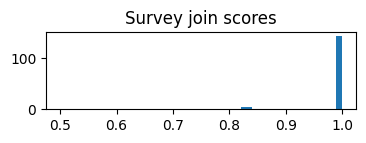

143 perfect matches of 153 total


In [75]:
# sanity-check the join scores: they should be very high!
fig, ax = plt.subplots(1, 1, figsize=(4, 1))

ax.hist(joined_df.matching_score, bins=50)
ax.set_title("Survey join scores")

plt.show()
print(f"{(joined_df.matching_score >= 0.99).sum()} perfect matches of {len(joined_df)} total")

In [76]:
join_display_cols = [
    "matching_score",
    "ranking_q",
    "generation_index",
    "query",
    "query_survey",
    "document",
    "document_survey",
    "generation",
    "generation_survey",
]
joined_df[joined_df.matching_score < 1][join_display_cols].sort_values("matching_score").head()

,matching_score,ranking_q,generation_index,query,query_survey,document,document_survey,generation,generation_survey
26,0.500000,Q33,3,Can someone help me with what an irrational nu...,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,Identify Rational Numbers and Irrational Numbe...,Of course! I'd be happy to help explain the di...,"No, a rational number and an irrational number..."
100,0.821084,Q2,1,Can function Notation be negative?,Can function Notation be negative?,Locate Positive and Negative Numbers on the Nu...,Locate Positive and Negative Numbers on the Nu...,"No, function notation cannot be negative. Func...","No, function notation cannot be negative. Func..."
99,0.821094,Q2,2,Can function Notation be negative?,Can function Notation be negative?,Locate Positive and Negative Numbers on the Nu...,Locate Positive and Negative Numbers on the Nu...,"No, function notation itself cannot be negativ...","No, function notation itself cannot be negativ..."
101,0.823407,Q2,3,Can function Notation be negative?,Can function Notation be negative?,Locate Positive and Negative Numbers on the Nu...,Locate Positive and Negative Numbers on the Nu...,"No, function notation cannot be negative. Func...","No, function notation cannot be negative. Func..."
116,0.825255,Q45,3,How do i graph an inequality with a less than ...,How do i graph an inequality with a less than ...,Locate Positive and Negative Numbers on the Nu...,Locate Positive and Negative Numbers on the Nu...,To graph an inequality with a less than or equ...,To graph an inequality with a less than or equ...


In [77]:
expected_minimum_matching_score = 0.5
assert (joined_df.matching_score >= expected_minimum_matching_score).all()

In [78]:
joined_df.columns

Index(['query', 'document', 'generation', 'query_set', 'guidance', 'messages',
       'corpus', 'query_survey', 'document_survey', 'generation_index',
       'generation_survey', 'survey_id', 'ranking_q', 'faithfulness_q',
       'matching_score'],
      dtype='object')

In [79]:
joined_df.iloc[26]

query                Can someone help me with what an irrational nu...
document             Identify Rational Numbers and Irrational Numbe...
generation           Of course! I'd be happy to help explain the di...
query_set                                                  math_nation
guidance                                                          none
messages             [{'role': 'system', 'content': 'You are going ...
corpus                                                            math
query_survey         Is a rational and irrational number always irr...
document_survey      Identify Rational Numbers and Irrational Numbe...
generation_index                                                     3
generation_survey    No, a rational number and an irrational number...
survey_id                                                Rori+survey+2
ranking_q                                                          Q33
faithfulness_q                                                     Q34
matchi

In [80]:
joined_df.groupby(["survey_id", "ranking_q"]).generation.count()

survey_id      ranking_q
Rori+survey+1  Q2           3
               Q27          3
               Q30          3
               Q33          3
               Q36          3
               Q39          3
               Q42          3
               Q45          3
               Q48          3
               Q51          3
               Q54          3
               Q57          3
               Q60          3
               Q63          3
               Q66          3
Rori+survey+2  Q2           3
               Q27          3
               Q30          3
               Q33          4
               Q36          3
               Q39          3
               Q42          3
               Q45          3
               Q48          3
               Q51          3
               Q54          3
               Q57          3
               Q60          3
               Q63          3
               Q66          3
Rori+survey+3  Q2           3
               Q27          3
               

In [81]:
# should be 3 for all questions
joined_df.groupby(["survey_id", "ranking_q"]).generation_index.nunique()

survey_id      ranking_q
Rori+survey+1  Q2           3
               Q27          3
               Q30          3
               Q33          3
               Q36          3
               Q39          3
               Q42          3
               Q45          3
               Q48          3
               Q51          3
               Q54          3
               Q57          3
               Q60          3
               Q63          3
               Q66          3
Rori+survey+2  Q2           3
               Q27          3
               Q30          3
               Q33          3
               Q36          3
               Q39          3
               Q42          3
               Q45          3
               Q48          3
               Q51          3
               Q54          3
               Q57          3
               Q60          3
               Q63          3
               Q66          3
Rori+survey+3  Q2           3
               Q27          3
               

In [82]:
joined_df[(joined_df.survey_id == "Rori+survey+4") & (joined_df.ranking_q == "Q54")][join_display_cols]

,matching_score,ranking_q,generation_index,query,query_survey,document,document_survey,generation,generation_survey
24,1.0,Q54,2,Can someone help me with what an irrational nu...,Can someone help me with what an irrational nu...,Identify Rational Numbers and Irrational Numbe...,Identify Rational Numbers and Irrational Numbe...,Of course! I can definitely help you understan...,Of course! I can definitely help you understan...
25,1.0,Q54,3,Can someone help me with what an irrational nu...,Can someone help me with what an irrational nu...,Identify Rational Numbers and Irrational Numbe...,Identify Rational Numbers and Irrational Numbe...,Rational numbers are numbers that can be writt...,Rational numbers are numbers that can be writt...


In [83]:
joined_df[(joined_df.survey_id == "Rori+survey+2") & (joined_df.ranking_q == "Q33")][join_display_cols]

,matching_score,ranking_q,generation_index,query,query_survey,document,document_survey,generation,generation_survey
26,0.5,Q33,3,Can someone help me with what an irrational nu...,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,Identify Rational Numbers and Irrational Numbe...,Of course! I'd be happy to help explain the di...,"No, a rational number and an irrational number..."
87,1.0,Q33,3,Is a rational and irrational number always irr...,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,Identify Rational Numbers and Irrational Numbe...,"No, a rational number and an irrational number...","No, a rational number and an irrational number..."
88,1.0,Q33,2,Is a rational and irrational number always irr...,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,Identify Rational Numbers and Irrational Numbe...,"No, actually a rational number can't be irrati...","No, actually a rational number can't be irrati..."
89,1.0,Q33,1,Is a rational and irrational number always irr...,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,Identify Rational Numbers and Irrational Numbe...,A rational number is a number that can be writ...,A rational number is a number that can be writ...


In [84]:
survey_question_df[(survey_question_df.survey_id == "Rori+survey+4") & (survey_question_df.ranking_q == "Q54")]

,query,document,generation_index,generation,survey_id,ranking_q,faithfulness_q
105,Can someone help me with what an irrational nu...,Identify Rational Numbers and Irrational Numbe...,1,Of course! I'd be happy to help explain the di...,Rori+survey+4,Q54,Q55
106,Can someone help me with what an irrational nu...,Identify Rational Numbers and Irrational Numbe...,2,Of course! I can definitely help you understan...,Rori+survey+4,Q54,Q55
107,Can someone help me with what an irrational nu...,Identify Rational Numbers and Irrational Numbe...,3,Rational numbers are numbers that can be writt...,Rori+survey+4,Q54,Q55


In [85]:
survey_question_df[(survey_question_df.survey_id == "Rori+survey+2") & (survey_question_df.ranking_q == "Q33")]

,query,document,generation_index,generation,survey_id,ranking_q,faithfulness_q
81,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,1,A rational number is a number that can be writ...,Rori+survey+2,Q33,Q34
82,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,2,"No, actually a rational number can't be irrati...",Rori+survey+2,Q33,Q34
83,Is a rational and irrational number always irr...,Identify Rational Numbers and Irrational Numbe...,3,"No, a rational number and an irrational number...",Rori+survey+2,Q33,Q34


In [86]:
# map joined_df iloc 26 to the survey_question_df iloc that corresponds
for survey_column in survey_question_df.columns:
    source_column = survey_column
    if survey_column in question_df.columns:
        source_column = survey_column + "_survey"
    joined_df.loc[26, source_column] = survey_question_df.iloc[105][survey_column]
joined_df.iloc[26]

query                Can someone help me with what an irrational nu...
document             Identify Rational Numbers and Irrational Numbe...
generation           Of course! I'd be happy to help explain the di...
query_set                                                  math_nation
guidance                                                          none
messages             [{'role': 'system', 'content': 'You are going ...
corpus                                                            math
query_survey         Can someone help me with what an irrational nu...
document_survey      Identify Rational Numbers and Irrational Numbe...
generation_index                                                     1
generation_survey    Of course! I'd be happy to help explain the di...
survey_id                                                Rori+survey+4
ranking_q                                                          Q54
faithfulness_q                                                     Q55
matchi

In [87]:
# should be 3 generations associated with each survey/question
assert (joined_df.groupby(["survey_id", "ranking_q"]).generation_index.nunique() == 3).all()
assert (joined_df.groupby(["survey_id", "faithfulness_q"]).generation_index.nunique() == 3).all()

In [88]:
joined_df.groupby(["survey_id", "ranking_q"]).generation_index.nunique()

survey_id      ranking_q
Rori+survey+1  Q2           3
               Q27          3
               Q30          3
               Q33          3
               Q36          3
               Q39          3
               Q42          3
               Q45          3
               Q48          3
               Q51          3
               Q54          3
               Q57          3
               Q60          3
               Q63          3
               Q66          3
Rori+survey+2  Q2           3
               Q27          3
               Q30          3
               Q33          3
               Q36          3
               Q39          3
               Q42          3
               Q45          3
               Q48          3
               Q51          3
               Q54          3
               Q57          3
               Q60          3
               Q63          3
               Q66          3
Rori+survey+3  Q2           3
               Q27          3
               

In [89]:
joined_df.head(3)[join_display_cols]

,matching_score,ranking_q,generation_index,query,query_survey,document,document_survey,generation,generation_survey
0,1.0,Q57,1,What is vertex form and how do you solve for it?,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...","Use the Distance, Rate, and Time Formula: One ...","Vertex form, also known as completed square fo...","Vertex form, also known as completed square fo..."
1,1.0,Q57,3,What is vertex form and how do you solve for it?,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...","Use the Distance, Rate, and Time Formula: One ...",Vertex form is a specific form of writing quad...,Vertex form is a specific form of writing quad...
2,1.0,Q57,2,What is vertex form and how do you solve for it?,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...","Use the Distance, Rate, and Time Formula: One ...",Vertex form is a way to write the equation of ...,Vertex form is a way to write the equation of ...


In [90]:
ds = []
for survey_id, sdf in survey_df_map.items():
    sjdf = joined_df[joined_df.survey_id == survey_id]
    paired_qs = set(zip(sjdf.ranking_q, sjdf.faithfulness_q))
    for ranking_q, faithfulness_q in paired_qs:
        for suffix in ["_1", "_2", "_3"]:
            i = int(suffix[1])
            for annotator, rank, faithfulness in zip(
                sdf.loc[2:, "annotator_name"], sdf.loc[2:, ranking_q + suffix], sdf.loc[2:, faithfulness_q + suffix]
            ):
                d = {
                    "survey_id": survey_id,
                    "annotator": annotator,
                    "ranking_q": ranking_q,
                    "faithfulness_q": faithfulness_q,
                    "generation_index": i,
                    "preference_rank": rank,
                    "faithfulness": faithfulness,
                }
                ds.append(d)
ranking_df = pd.DataFrame(ds)
ranking_df.shape

(612, 7)

In [91]:
ranking_df.annotator.value_counts(dropna=False)

annotator
Anoushka                 90
test                     90
Chenglu Li               90
Urmil Patel              63
KAVITHA SREE             63
Sannidhi                 45
Millie                   45
Hannah HR (with Rori)    45
Zach                     45
Hannah HR (rori)         18
Owen                     18
Name: count, dtype: int64

In [92]:
# merge annotators
ranking_df.loc[ranking_df.annotator.str.startswith("Hannah HR"), "annotator"] = "Hannah HR"
ranking_df.drop(ranking_df[ranking_df.annotator == "test"].index, inplace=True)
ranking_df.annotator.value_counts()

annotator
Anoushka        90
Chenglu Li      90
Urmil Patel     63
KAVITHA SREE    63
Hannah HR       63
Sannidhi        45
Millie          45
Zach            45
Owen            18
Name: count, dtype: int64

In [93]:
display(pd.crosstab(ranking_df.annotator, ranking_df.preference_rank, dropna=False))
display(pd.crosstab(ranking_df.annotator, ranking_df.faithfulness, dropna=False))

preference_rank,1,2,3,NaN
annotator,,,,
Anoushka,30,30,30,0
Chenglu Li,30,30,30,0
Hannah HR,21,21,21,0
KAVITHA SREE,18,18,18,9
Millie,15,15,15,0
Owen,6,6,6,0
Sannidhi,15,15,15,0
Urmil Patel,21,21,21,0
Zach,15,15,15,0


faithfulness,None,Partial,Perfect,NaN
annotator,,,,
Anoushka,40,32,18,0
Chenglu Li,24,34,32,0
Hannah HR,25,23,15,0
KAVITHA SREE,40,12,2,9
Millie,16,19,10,0
Owen,10,8,0,0
Sannidhi,24,12,9,0
Urmil Patel,56,6,1,0
Zach,19,21,5,0


In [94]:
ranking_df.columns

Index(['survey_id', 'annotator', 'ranking_q', 'faithfulness_q',
       'generation_index', 'preference_rank', 'faithfulness'],
      dtype='object')

In [95]:
joined_df.columns

Index(['query', 'document', 'generation', 'query_set', 'guidance', 'messages',
       'corpus', 'query_survey', 'document_survey', 'generation_index',
       'generation_survey', 'survey_id', 'ranking_q', 'faithfulness_q',
       'matching_score'],
      dtype='object')

In [96]:
# annotators per question
df = joined_df.merge(ranking_df, how="left", on=["survey_id", "ranking_q", "faithfulness_q", "generation_index"])
df.groupby(["survey_id", "ranking_q", "generation_index"]).annotator.nunique(dropna=False).rename(
    "annotators per question"
).value_counts(dropna=False)

annotators per question
3    90
4    63
Name: count, dtype: int64

In [97]:
# merge in relevance annotations
df = df.join(mean_relevance_series, on="query")
assert df["mean_relevance"].notna().all()

In [98]:
df[["survey_id", "ranking_q", "generation_index", "annotator", "preference_rank", "mean_relevance"]].head(12)

,survey_id,ranking_q,generation_index,annotator,preference_rank,mean_relevance
0,Rori+survey+3,Q57,1,Urmil Patel,2,0.333333
1,Rori+survey+3,Q57,1,Sannidhi,2,0.333333
2,Rori+survey+3,Q57,1,Anoushka,2,0.333333
3,Rori+survey+3,Q57,3,Urmil Patel,3,0.333333
4,Rori+survey+3,Q57,3,Sannidhi,3,0.333333
5,Rori+survey+3,Q57,3,Anoushka,3,0.333333
6,Rori+survey+3,Q57,2,Urmil Patel,1,0.333333
7,Rori+survey+3,Q57,2,Sannidhi,1,0.333333
8,Rori+survey+3,Q57,2,Anoushka,1,0.333333
9,Rori+survey+3,Q51,1,Urmil Patel,3,1.333333


In [99]:
# save outcome df
df.to_csv(data_dir / "derived" / "outcome_df.csv")

In [100]:
for c1, c2 in itertools.combinations(["low", "none", "high"], 2):
    prefer_c1 = []
    for key, group in df.groupby(["survey_id", "ranking_q", "annotator"]):
        c1_rank = group.loc[group.guidance == c1, "preference_rank"].iloc[0]
        c2_rank = group.loc[group.guidance == c2, "preference_rank"].iloc[0]
        prefer_c1.append(c1_rank < c2_rank)
    prefer_c1 = np.array(prefer_c1)
    count = prefer_c1.sum()
    nobs = len(prefer_c1)
    pct = count / nobs
    conf = statsmodels.stats.proportion.proportion_confint(count, nobs, alpha=0.05, method="normal")
    print(f"Annotators prefer {c1} to {c2} {pct:.2%} of the time (n={nobs}, {count=}, conf={conf})")

Annotators prefer low to none 57.47% of the time (n=174, count=100, conf=(0.5012544781568573, 0.6481708091994645))
Annotators prefer low to high 63.79% of the time (n=174, count=111, conf=(0.5665215360441147, 0.7093405329214026))
Annotators prefer none to high 51.72% of the time (n=174, count=90, conf=(0.44299331833095906, 0.5914894402897306))


In [101]:
def get_numeric_faithfulness(faithfulness):
    if faithfulness == "Partial":
        return 1
    elif faithfulness == "Perfect":
        return 2
    else:
        return 0


def get_mean_faithfulness(group):
    group = group.map(get_numeric_faithfulness)
    return group.mean()


faithfulness_df = (
    df.groupby(["survey_id", "faithfulness_q", "query", "mean_relevance", "guidance"])
    .faithfulness.apply(get_mean_faithfulness)
    .reset_index()
)
faithfulness_df.head()

,survey_id,faithfulness_q,query,mean_relevance,guidance,faithfulness
0,Rori+survey+1,Q28,Is supplementary angles are always adjacent,1.333333,high,1.75
1,Rori+survey+1,Q28,Is supplementary angles are always adjacent,1.333333,low,1.25
2,Rori+survey+1,Q28,Is supplementary angles are always adjacent,1.333333,none,1.25
3,Rori+survey+1,Q3,Can someone give me a factoring example I don...,2.333333,high,1.25
4,Rori+survey+1,Q3,Can someone give me a factoring example I don...,2.333333,low,1.50


In [102]:
for guidance, group in faithfulness_df.groupby("guidance"):
    print(f"{guidance} responses have mean faithfulness {group.faithfulness.mean():.3f}")
faithfulness_df.groupby("guidance").faithfulness.mean().reset_index()

high responses have mean faithfulness 0.881
low responses have mean faithfulness 0.577
none responses have mean faithfulness 0.513


,guidance,faithfulness
0,high,0.880719
1,low,0.576797
2,none,0.513072


In [103]:
# create an annotator-level faithfulness df
annotator_faithfulness_df = df[["survey_id", "faithfulness_q", "guidance", "annotator", "faithfulness"]].copy()
annotator_faithfulness_df["faithfulness"] = annotator_faithfulness_df.faithfulness.map(get_numeric_faithfulness)
annotator_faithfulness_df.head(2)

,survey_id,faithfulness_q,guidance,annotator,faithfulness
0,Rori+survey+3,Q58,none,Urmil Patel,0
1,Rori+survey+3,Q58,none,Sannidhi,0


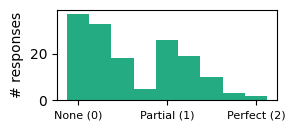

In [104]:
sdf = faithfulness_df
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 1.1))

faithfulness_answers = ["none", "partial", "perfect"]

xs = sdf.faithfulness

bin_width = 0.25
bins = np.arange(0, len(faithfulness_answers) - (bin_width * 2), bin_width)
ax.hist(xs, bins=bins, align="left", color=matplotlib.cm.viridis(0.61))
ax.set_xticks(
    list(range(len(faithfulness_answers))),
    labels=[f"{answer.capitalize()} ({i})" for i, answer in enumerate(faithfulness_answers)],
    fontsize=8,
)
# ax.set_yticks([0, 2, 4, 6, 8])
ax.set_ylabel("# responses")

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "mean_faithfulness.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
plt.show()

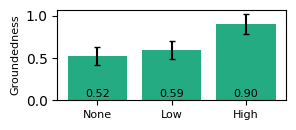

In [108]:
sdf = annotator_faithfulness_df
color = matplotlib.cm.viridis(0.61)

fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 1.1))

guidance_conditions = ["none", "low", "high"]
for i, guidance in enumerate(guidance_conditions):
    ssdf = sdf[sdf.guidance == guidance]
    mean = ssdf.faithfulness.mean()
    low, high = statsmodels.stats.weightstats.zconfint(ssdf.faithfulness, alpha=0.05)
    low_delta = mean - low
    high_delta = high - mean
    ax.bar(i, mean, color=color)
    ax.errorbar((i,), (mean,), yerr=((low_delta,), (high_delta,)), color="black", capsize=2)
    ax.text(i, 0.02, f"{mean:.2f}", va="bottom", ha="center", fontsize=8)
ax.set_xticks([0, 1, 2], ["None", "Low", "High"], fontsize=8)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel("Groundedness", fontsize=8)
# caption: mean faithfulness on the ordinal None (0), Partial (1), Perfect (2) scale

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "faithfulness_by_guidance.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
plt.show()

In [109]:
# Difference between faithfulness in the guidance conditions?
statsmodels.stats.oneway.anova_oneway(
    [list(faithfulness_df[faithfulness_df.guidance == guidance].faithfulness) for guidance in ["none", "low", "high"]],
)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 6.647166598213678
pvalue = 0.0019506984744445746
df = (2.0, 99.63192852086512)
df_num = 2.0
df_denom = 99.63192852086512
nobs_t = 153.0
n_groups = 3
means = array([0.5130719 , 0.57679739, 0.88071895])
nobs = array([51., 51., 51.])
vars_ = array([0.24038126, 0.29412309, 0.31868192])
use_var = 'unequal'
welch_correction = True
tuple = (6.647166598213678, 0.0019506984744445746)

In [110]:
for c1, c2 in itertools.combinations(["low", "none", "high"], 2):
    g1 = faithfulness_df[faithfulness_df.guidance == c1].faithfulness
    g2 = faithfulness_df[faithfulness_df.guidance == c2].faithfulness
    cm = statsmodels.stats.weightstats.CompareMeans.from_data(g1, g2)
    print(c1, c2)
    print(cm.summary())
    print(cm.ztest_ind())

low none
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.0637      0.102      0.622      0.535      -0.139       0.267
(0.6224760521678682, 0.5336288859091554)
low high
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.3039      0.110     -2.773      0.007      -0.521      -0.086
(-2.7725887466298222, 0.005561235307857308)
none high
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.3

In [135]:
# reliability_data = [relevance_df[annotator].map(get_numeric_relevance) for annotator in relevance_annotators]
# krippendorff.alpha(reliability_data=reliability_data, level_of_measurement="ordinal")

In [438]:
faithfulness_df.head()

,survey_id,faithfulness_q,guidance,faithfulness
0,Rori+survey+1,Q28,high,1.75
1,Rori+survey+1,Q28,low,1.25
2,Rori+survey+1,Q28,none,1.25
3,Rori+survey+1,Q3,high,1.25
4,Rori+survey+1,Q3,low,1.50


In [112]:
for condition, sdf in [
    ("all", annotator_faithfulness_df),
    ("none_only", annotator_faithfulness_df[annotator_faithfulness_df.guidance == "none"]),
    ("low_only", annotator_faithfulness_df[annotator_faithfulness_df.guidance == "low"]),
    ("high_only", annotator_faithfulness_df[annotator_faithfulness_df.guidance == "high"]),
]:
    annotators = set(sdf.annotator)
    question_keys = set()
    annotator_faithfulness_map = {}
    for row in sdf.itertuples():
        # row.survey_id, row.faithfulness_q, row.guidance, row.annotator
        question_key = (row.survey_id, row.faithfulness_q, row.guidance)
        question_keys.add(question_key)
        annotator_faithfulness_map[question_key + (row.annotator,)] = (
            row.faithfulness if pd.notna(row.faithfulness) else np.nan
        )

    reliability_data = [
        [
            annotator_faithfulness_map[question_key + (annotator,)]
            if question_key + (annotator,) in annotator_faithfulness_map
            else np.nan
            for question_key in question_keys
        ]
        for annotator in annotators
    ]
    assert len(reliability_data) == len(annotators)
    k_alpha = krippendorff.alpha(reliability_data=reliability_data, level_of_measurement="ordinal")
    print(
        f"Krippendorff's alpha for condition {condition}: {k_alpha:.4f} (n={len(question_keys)}, {len(reliability_data)} raters)"
    )

Krippendorff's alpha for condition all: 0.3450 (n=153, 9 raters)
Krippendorff's alpha for condition none_only: 0.2563 (n=51, 9 raters)
Krippendorff's alpha for condition low_only: 0.3524 (n=51, 9 raters)
Krippendorff's alpha for condition high_only: 0.3236 (n=51, 9 raters)


In [113]:
for guidance in ["none", "low", "high", "all"]:
    if guidance == "all":
        sdf = faithfulness_df
    else:
        sdf = faithfulness_df[faithfulness_df.guidance == guidance]
    r, p = scipy.stats.pearsonr(sdf.mean_relevance, sdf.faithfulness)
    print(f"{guidance=} n={len(sdf)} r={r:.4f} (p={p:.4f}, p_bonf.={p*4:.4f})")

guidance='none' n=51 r=0.7046 (p=0.0000, p_bonf.=0.0000)
guidance='low' n=51 r=0.6745 (p=0.0000, p_bonf.=0.0000)
guidance='high' n=51 r=0.6159 (p=0.0000, p_bonf.=0.0000)
guidance='all' n=153 r=0.6333 (p=0.0000, p_bonf.=0.0000)


none
                            OLS Regression Results                            
Dep. Variable:           faithfulness   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     48.31
Date:                Sun, 24 Sep 2023   Prob (F-statistic):           7.92e-09
Time:                        22:19:46   Log-Likelihood:                -18.015
No. Observations:                  51   AIC:                             40.03
Df Residuals:                      49   BIC:                             43.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0726      0.098   

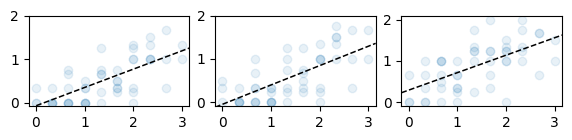

In [114]:
# explore correlation between relevance and faithfulness in the math corpus
# we would expect a small positive correlation
# when guidance is high, we expect a stronger correlation
fig, axes = plt.subplots(1, 3, figsize=(COLUMN_WIDTH_IN, 1.2))
axes = axes.reshape(-1)


def plot_relevance_vs_faithfulness(ax, sdf, guidance):
    # correlation
    r, p = scipy.stats.pearsonr(sdf.mean_relevance, sdf.faithfulness)
    # and the approximately equivalent linear regression
    # https://sebastianraschka.com/faq/docs/pearson-r-vs-linear-regr.html
    model = sm.OLS.from_formula(formula="faithfulness ~ mean_relevance", data=sdf)
    model = model.fit()
    params = model.params

    # ax.hist2d(sdf.mean_relevance, sdf.mean_faithfulness, cmin=1)
    ax.scatter(sdf.mean_relevance, sdf.faithfulness, alpha=0.1, marker="o")
    # ax.set_xlabel("Mean relevance")
    # ax.set_ylabel("Mean faithfulness")

    ax.set_yticks([0, 1, 2])
    ax.set_xticks([0, 1, 2, 3])

    statsmodels.graphics.regressionplots.abline_plot(
        model_results=model,
        ax=ax,
        color="black",
        linestyle="--",
        linewidth=1.1,
        label=f"OLS ($r$={r:.3f}, $p$={p:.3f})",
    )
    # ax.legend()
    print(guidance)
    print(model.summary())
    print(f"Pearson's correlation ($r$={r:.3f}, $p$={p:.3f})")


guidance_conditions = ["none", "low", "high"]
for ax_ind, guidance in enumerate(guidance_conditions):
    ax = axes[ax_ind]
    sdf = faithfulness_df[faithfulness_df.guidance == guidance]
    plot_relevance_vs_faithfulness(ax, sdf, guidance)

fig.tight_layout(pad=0, w_pad=0.51)
plt.show()

                            OLS Regression Results                            
Dep. Variable:           faithfulness   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     101.1
Date:                Sun, 24 Sep 2023   Prob (F-statistic):           1.57e-18
Time:                        22:20:02   Log-Likelihood:                -86.926
No. Observations:                 153   AIC:                             177.9
Df Residuals:                     151   BIC:                             183.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0584      0.069      0.

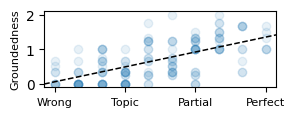

In [115]:
# explore correlation between relevance and faithfulness in the math corpus
# we would expect a small positive correlation
# when guidance is high, we expect a stronger correlation
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 0.98))


def plot_relevance_vs_faithfulness(ax, sdf):
    # correlation
    r, p = scipy.stats.pearsonr(sdf.mean_relevance, sdf.faithfulness)
    # and the approximately equivalent linear regression
    # https://sebastianraschka.com/faq/docs/pearson-r-vs-linear-regr.html
    model = sm.OLS.from_formula(formula="faithfulness ~ mean_relevance", data=sdf)
    model = model.fit()
    params = model.params

    ax.scatter(sdf.mean_relevance, sdf.faithfulness, alpha=0.1, marker="o")

    ax.set_yticks([0, 1, 2])
    ax.set_xticks([0, 1, 2, 3], labels=["Wrong", "Topic", "Partial", "Perfect"], fontsize=8)

    statsmodels.graphics.regressionplots.abline_plot(
        model_results=model,
        ax=ax,
        color="black",
        linestyle="--",
        linewidth=1.1,
        label=f"OLS ($r$={r:.3f}, $p$={p:.3f})",
    )
    print(model.summary())
    print(f"Pearson's correlation ($r$={r:.3f}, $p$={p:.3f})")

    # ax.set_xlabel("Relevance")
    ax.set_ylabel("Groundedness", fontsize=8)


plot_relevance_vs_faithfulness(ax, faithfulness_df)

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "relevance_x_faithfulness.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)

plt.show()

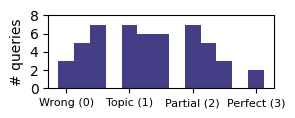

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 0.98))

xs = faithfulness_df.drop_duplicates(subset=["query"], keep="first").mean_relevance

bin_width = 0.25
bins = np.arange(0, len(relevance_answers) - (bin_width * 2), bin_width)
ax.hist(xs, bins=bins, align="left", color=matplotlib.cm.viridis(0.18))
ax.set_xticks(
    list(range(len(relevance_answers))),
    labels=[f"{answer.capitalize()} ({i})" for i, answer in enumerate(relevance_answers)],
    fontsize=8,
)
ax.set_yticks([0, 2, 4, 6, 8])

# ax.set_xlabel("Mean relevance")
ax.set_ylabel("# queries")

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "mean_relevance.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
plt.show()

In [117]:
autometric_faithfulness_df = faithfulness_df.merge(
    autometric_df, on=["query", "guidance"], suffixes=("", "_am"), how="left"
)
autometric_faithfulness_df.head(1)

,survey_id,faithfulness_q,query,mean_relevance,guidance,faithfulness,Index,query_set,generation,document,messages,corpus,f1,bleurt,bertscore
0,Rori+survey+1,Q28,Is supplementary angles are always adjacent,1.333333,high,1.75,192,math_nation,Supplementary angles are not always adjacent. ...,Use the Properties of Angles: Are you familiar...,"[{'role': 'system', 'content': 'You are going ...",math,0.424242,-0.494919,0.834581


In [119]:
# human annotations vs metrics
tabular_top = """\\begin{tabular}{@{}lllllll@{}}
\\toprule
Guidance & \\multicolumn{3}{c}{Faithfulness} & \\multicolumn{3}{c}{Relevance} \\\\
& K-F1++   & BLEURT   & BERTScore  & K-F1++  & BLEURT  & BERTScore \\\\ \\midrule"""
print(tabular_top)
for guidance in ["none", "low", "high", "pooled"]:
    if guidance == "pooled":
        sdf = autometric_faithfulness_df
    else:
        sdf = autometric_faithfulness_df[autometric_faithfulness_df.guidance == guidance]
    r_vals = []
    for human_key in ["faithfulness", "mean_relevance"]:
        for metric_key in ["f1", "bleurt", "bertscore"]:
            r, p = scipy.stats.pearsonr(sdf[metric_key], sdf[human_key])
            p = p * 12
            r_val = f"{r:.2f}"
            if p <= 0.001:
                r_val += "$^{***}$"
            elif p <= 0.01:
                r_val += "$^{**}$"
            elif p <= 0.05:
                r_val += "$^{*}$"
            r_vals.append(r_val)

    entries = "&".join(r_vals)
    tabular_row = f"{guidance.capitalize()} & {entries} \\\\"
    if guidance == "pooled":
        tabular_row += " \\bottomrule"
    elif guidance == "high":
        tabular_row += " \\midrule"
    print(tabular_row)
tabular_bottom = "\\end{tabular}"
print(tabular_bottom)

\begin{tabular}{@{}lllllll@{}}
\toprule
Guidance & \multicolumn{3}{c}{Faithfulness} & \multicolumn{3}{c}{Relevance} \\
& K-F1++   & BLEURT   & BERTScore  & K-F1++  & BLEURT  & BERTScore \\ \midrule
None & 0.38&0.33&0.35&0.26&0.34&0.43$^{*}$ \\
Low & 0.47$^{**}$&0.32&0.61$^{***}$&0.43$^{*}$&0.34&0.50$^{**}$ \\
High & 0.50$^{**}$&0.21&0.39&0.37&0.26&0.50$^{**}$ \\ \midrule
Pooled & 0.52$^{***}$&0.33$^{***}$&0.51$^{***}$&0.31$^{**}$&0.30$^{**}$&0.42$^{***}$ \\ \bottomrule
\end{tabular}


In [134]:
if False:  # I don' think I ever ran this cell here
    fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 1.2))

    xs = faithfulness_df.drop_duplicates(subset=["query"], keep="first").mean_relevance

    bin_width = 0.25
    bins = np.arange(0, len(relevance_answers) - (bin_width * 2), bin_width)
    ax.hist(xs, bins=bins, align="left", color=matplotlib.cm.viridis(0.18))
    ax.set_xticks(
        list(range(len(relevance_answers))),
        labels=[f"{answer.capitalize()} ({i})" for i, answer in enumerate(relevance_answers)],
        fontsize=8,
    )
    ax.set_yticks([0, 2, 4, 6, 8])

    # ax.set_xlabel("Mean relevance")
    ax.set_ylabel("# queries")

    fig.tight_layout(pad=0)
    fig.savefig(figures_dir / "mean_relevance.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
    plt.show()

In [129]:
guidance_conditions = np.array(["none", "low", "high"])
permutations = [permutation for permutation in itertools.permutations(guidance_conditions, 3)]
rank_orders = []
n_skipped = 0
for key, group in df.groupby(["survey_id", "ranking_q", "annotator"]):
    if group.preference_rank.isna().any():
        n_skipped += 1
        continue
    ranks = [group.loc[group.guidance == guidance, "preference_rank"].iloc[0] for guidance in guidance_conditions]
    rank_order = tuple(guidance_conditions[np.argsort(ranks)])
    assert rank_order in permutations
    rank_orders.append(rank_order)
len(rank_orders), n_skipped

(171, 3)

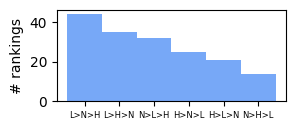

In [130]:
color = "#77a8f7"
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 1.1))

permutation_counts = Counter(rank_orders).most_common()
i = 0
for permutation, permutation_count in permutation_counts:
    ax.bar(i, permutation_count, width=1, color=color)
    i += 1

ax.set_xticks(
    range(len(permutation_counts)),
    [f"{p[0][0].capitalize()}>{p[1][0].capitalize()}>{p[2][0].capitalize()}" for p, _ in permutation_counts],
    fontsize=6,
)
ax.set_yticks([0, 20, 40])
ax.set_ylabel("# rankings")  # response/annotator pairs

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "rank_distribution.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
plt.show()

Annotators prefer low to high 63.79% of the time (n=174, count=111, conf=(0.5665215360441147, 0.7093405329214026))
Annotators prefer low to none 57.47% of the time (n=174, count=100, conf=(0.5012544781568573, 0.6481708091994645))
Annotators prefer none to high 51.72% of the time (n=174, count=90, conf=(0.44299331833095906, 0.5914894402897306))


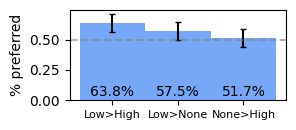

In [133]:
color = "#77a8f7"
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 1.1))

i = 0
xtick_labels = []
for c1, c2 in itertools.combinations(["low", "high", "none"], 2):
    if c1 == "high" and c2 == "none":
        c1 = "none"
        c2 = "high"
    prefer_c1 = []
    for key, group in df.groupby(["survey_id", "ranking_q", "annotator"]):
        c1_rank = group.loc[group.guidance == c1, "preference_rank"].iloc[0]
        c2_rank = group.loc[group.guidance == c2, "preference_rank"].iloc[0]
        prefer_c1.append(c1_rank < c2_rank)
    prefer_c1 = np.array(prefer_c1)
    count = prefer_c1.sum()
    nobs = len(prefer_c1)
    pct = count / nobs
    conf = statsmodels.stats.proportion.proportion_confint(count, nobs, alpha=0.05, method="normal")
    print(f"Annotators prefer {c1} to {c2} {pct:.2%} of the time (n={nobs}, {count=}, conf={conf})")
    low_delta = pct - conf[0]
    high_delta = conf[1] - pct
    xtick_labels.append(f"{c1.capitalize()}>{c2.capitalize()}")

    ax.bar(i, pct, width=1, color=color)
    ax.errorbar((i,), (pct,), yerr=((low_delta,), (high_delta,)), color="black", capsize=2)
    ax.text(i, 0.01, f"{pct:.1%}", ha="center", va="bottom")
    i += 1
ax.axhline(0.5, linestyle="--", color="gray", alpha=0.6)

ax.set_xticks(range(len(xtick_labels)), xtick_labels, fontsize=8)
# ax.set_yticks([0, 20, 40])
ax.set_ylabel("% preferred")

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "pairwise_ranks.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
plt.show()

In [150]:
# correlation between preference and faithfulness?
for guidance in ["none", "low", "high"]:
    sdf = df[(df.guidance == guidance) & (df.preference_rank.notna()) & (df.faithfulness.notna())]
    r, p = scipy.stats.pearsonr(3 - sdf.preference_rank.astype(int), sdf.faithfulness.map(get_numeric_faithfulness))
    print(f"For n={len(sdf)} in guidance condition {guidance}, corr is {r:.4f} (p={p:.4f})")

For n=171 in guidance condition none, corr is 0.1007 (p=0.1902)
For n=171 in guidance condition low, corr is -0.0814 (p=0.2898)
For n=171 in guidance condition high, corr is 0.0049 (p=0.9491)


Annotators prefer low to none 57.47% of the time (n=174, count=100, conf=(0.5012544781568573, 0.6481708091994645))
Annotators prefer low to high 63.79% of the time (n=174, count=111, conf=(0.5665215360441147, 0.7093405329214026))
Annotators prefer none to high 51.72% of the time (n=174, count=90, conf=(0.44299331833095906, 0.5914894402897306))


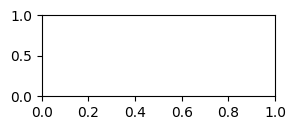

In [123]:
# I don't think this is fully implemented
color = "#77a8f7"
fig, ax = plt.subplots(1, 1, figsize=(COLUMN_WIDTH_IN / 2, 1.1))

i = 0
xtick_labels = []
for c1, c2 in itertools.combinations(["low", "none", "high"], 2):
    prefer_c1 = []
    for key, group in df.groupby(["survey_id", "ranking_q", "annotator"]):
        c1_rank = group.loc[group.guidance == c1, "preference_rank"].iloc[0]
        c2_rank = group.loc[group.guidance == c2, "preference_rank"].iloc[0]
        prefer_c1.append(c1_rank < c2_rank)
    prefer_c1 = np.array(prefer_c1)
    count = prefer_c1.sum()
    nobs = len(prefer_c1)
    pct = count / nobs
    conf = statsmodels.stats.proportion.proportion_confint(count, nobs, alpha=0.05, method="normal")
    print(f"Annotators prefer {c1} to {c2} {pct:.2%} of the time (n={nobs}, {count=}, conf={conf})")
    low_delta = pct - conf[0]
    high_delta = conf[1] - pct
    xtick_labels.append(f"{c1.capitalize()}>{c2.capitalize()}")

    # ax.bar(i, pct, width=1, color=color)
    # ax.errorbar((i,), (pct,), yerr=((low_delta,), (high_delta,)), color="black", capsize=2)
    # ax.text(i, 0.01, f"{pct:.1%}", ha="center", va="bottom")
    i += 1
# ax.axhline(0.5, linestyle="--", color="gray", alpha=0.6)

# ax.set_xticks(range(len(xtick_labels)), xtick_labels, fontsize=8)
# ax.set_ylabel("Relevance?")

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "relevance_rank_comparison.pdf", bbox_inches="tight", pad_inches=0.011, dpi=DPI)
plt.show()

In [124]:
for c1, c2 in itertools.combinations(["high", "low", "none"], 2):
    g1_relevance = []
    g2_relevance = []
    for key, group in df.groupby(["survey_id", "ranking_q", "annotator"]):
        c1_rank = group.loc[group.guidance == c1, "preference_rank"].iloc[0]
        c2_rank = group.loc[group.guidance == c2, "preference_rank"].iloc[0]
        prefer_c1 = c1_rank < c2_rank
        if prefer_c1:
            g1_relevance.append(group.iloc[0].mean_relevance)
        else:
            g2_relevance.append(group.iloc[0].mean_relevance)
    cm = statsmodels.stats.weightstats.CompareMeans.from_data(g1_relevance, g2_relevance)
    print(
        f"{c1}>{c2}: For queries where the {c1} response is preferred, mean relevance is {np.mean(g1_relevance):.3f}; when {c2} is preferred, mean relevance is {np.mean(g2_relevance):.3f}"
    )
    print(cm.summary())

high>low: For queries where the high response is preferred, mean relevance is 1.294; when low is preferred, mean relevance is 1.480
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.1851      0.128     -1.451      0.149      -0.437       0.067
high>none: For queries where the high response is preferred, mean relevance is 1.362; when none is preferred, mean relevance is 1.462
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.1002      0.122     -0.821      0.413      -0.341       0.141
low>none: For queries where the low response is preferred, mean relevance is 1.457; when none is prefe

In [ ]:
# guidance is discrete
# relevance is continuous
# hypothesis: the rank of high-guidance responses is lower (i.e. better) when relevance is higher

## Later analyses

During revisions for camera-ready and for presentations.

In [10]:
df = pd.read_csv(data_dir / "derived" / "outcome_df.csv")
df.head(1)

,Unnamed: 0,query,document,generation,query_set,guidance,messages,corpus,query_survey,document_survey,generation_index,generation_survey,survey_id,ranking_q,faithfulness_q,matching_score,annotator,preference_rank,faithfulness,mean_relevance
0,0,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...","Vertex form, also known as completed square fo...",math_nation,none,"[{'role': 'system', 'content': 'You are going ...",math,What is vertex form and how do you solve for it?,"Use the Distance, Rate, and Time Formula: One ...",1,"Vertex form, also known as completed square fo...",Rori+survey+3,Q57,Q58,1.0,Urmil Patel,2.0,NaN,0.333333


In [12]:
df.columns

Index(['Unnamed: 0', 'query', 'document', 'generation', 'query_set',
       'guidance', 'messages', 'corpus', 'query_survey', 'document_survey',
       'generation_index', 'generation_survey', 'survey_id', 'ranking_q',
       'faithfulness_q', 'matching_score', 'annotator', 'preference_rank',
       'faithfulness', 'mean_relevance'],
      dtype='object')

In [14]:
df.groupby("annotator").query.nunique().sort_values(ascending=False)

annotator
Anoushka        30
Chenglu Li      30
Hannah HR       21
KAVITHA SREE    21
Urmil Patel     21
Millie          15
Sannidhi        15
Zach            15
Owen             6
Name: query, dtype: int64

In [25]:
adf = df.groupby("annotator").query.nunique().sort_values(ascending=False).reset_index()
adf["annotator"] = [f"A{i+1}" for i, a in enumerate(adf.annotator)]
adf = adf.rename(columns={"annotator": "Annotator", "query": "Query Count"})
print(adf.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Annotator & Query Count \\
\midrule
A1 & 30 \\
A2 & 30 \\
A3 & 21 \\
A4 & 21 \\
A5 & 21 \\
A6 & 15 \\
A7 & 15 \\
A8 & 15 \\
A9 & 6 \\
\bottomrule
\end{tabular}



In [16]:
df.groupby("query").annotator.nunique().value_counts()

annotator
3    30
4    21
Name: count, dtype: int64

### Poster

Poster: https://gaied.org/neurips2023/files/40/40_poster.pdf

Annotators prefer low to high 63.79% of the time (n=174, count=111, conf=(0.5665215360441147, 0.7093405329214026))
Annotators prefer low to none 57.47% of the time (n=174, count=100, conf=(0.5012544781568573, 0.6481708091994645))
Annotators prefer none to high 51.72% of the time (n=174, count=90, conf=(0.44299331833095906, 0.5914894402897306))


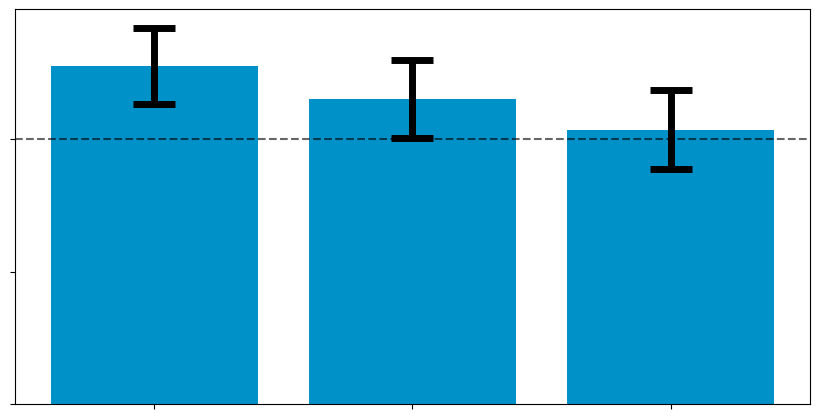

In [34]:
SMALL_SIZE = 26
MEDIUM_SIZE = 30
BIGGER_SIZE = 34

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

color = "#0091c9"
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

i = 0
xtick_labels = []
for c1, c2 in itertools.combinations(["low", "high", "none"], 2):
    if c1 == "high" and c2 == "none":
        c1 = "none"
        c2 = "high"
    prefer_c1 = []
    for key, group in df.groupby(["survey_id", "ranking_q", "annotator"]):
        c1_rank = group.loc[group.guidance == c1, "preference_rank"].iloc[0]
        c2_rank = group.loc[group.guidance == c2, "preference_rank"].iloc[0]
        prefer_c1.append(c1_rank < c2_rank)
    prefer_c1 = np.array(prefer_c1)
    count = prefer_c1.sum()
    nobs = len(prefer_c1)
    pct = count / nobs
    conf = statsmodels.stats.proportion.proportion_confint(count, nobs, alpha=0.05, method="normal")
    print(f"Annotators prefer {c1} to {c2} {pct:.2%} of the time (n={nobs}, {count=}, conf={conf})")
    low_delta = pct - conf[0]
    high_delta = conf[1] - pct
    xtick_labels.append(f"{c1.capitalize()}>{c2.capitalize()}")

    ax.bar(i, pct, width=0.8, color=color)
    ax.errorbar((i,), (pct,), yerr=((low_delta,), (high_delta,)), color="black", capsize=15, elinewidth=5, capthick=5)
    # ax.text(i, 0.01, f"{pct:.1%}", ha="center", va="bottom")
    i += 1
ax.axhline(0.5, linestyle="--", color="black", alpha=0.6)

ax.set_xticks(range(len(xtick_labels)), ["", "", ""])
ax.set_yticks([0, 0.25, 0.5], ["", "", ""])
# ax.set_yticks([0, 20, 40])
# ax.set_ylabel("% preferred")

fig.tight_layout(pad=0)
fig.savefig(figures_dir / "pairwise_ranks_poster.png", bbox_inches="tight", pad_inches=0.1, dpi=150)
plt.show()

### Presentation

In [ ]:
# load metric data

In [39]:
metric_df

,guidance,query_set,macro_f1,macro_f1_low,macro_f1_high,bleurt,bleurt_low,bleurt_high,bertscore,bertscore_low,bertscore_high
3,none,math_nation,0.270858,0.254724,0.286991,-0.571418,-0.619313,-0.523524,0.833604,0.830900,0.836308
2,low,math_nation,0.287759,0.269676,0.305841,-0.551136,-0.601682,-0.500591,0.836041,0.833053,0.839030
1,high,math_nation,0.355556,0.333788,0.377324,-0.464588,-0.522172,-0.407004,0.848303,0.844029,0.852577
0,extract_relevant,math_nation,0.672882,0.585646,0.760118,-0.480035,-0.612709,-0.347361,0.919087,0.903411,0.934763


In [120]:
slide_fig_width_in = 6
slide_fig_height_in = 3.5
slide_fig_dpi = 150

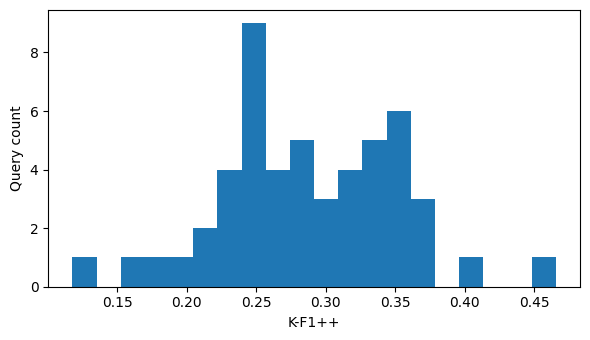

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(slide_fig_width_in, slide_fig_height_in))

xs = autometric_df[autometric_df.guidance == "low"].f1
ax.hist(xs, bins=20)
ax.set_ylabel("Query count")
ax.set_xlabel("K-F1++")

fig.tight_layout()
fig.savefig(figures_dir / "slides_kf1_hist.png", pad_inches=0.1, dpi=slide_fig_dpi)
plt.show()

0.29
0.36


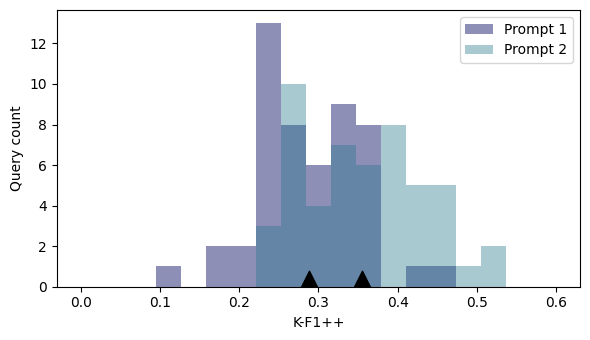

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(slide_fig_width_in, slide_fig_height_in))

xs_low = autometric_df[autometric_df.guidance == "low"].f1
xs_high = autometric_df[autometric_df.guidance == "high"].f1
bins = np.linspace(0, 0.6, num=20)
ax.hist(xs_low, bins=bins, log=False, alpha=0.6, color=matplotlib.cm.viridis(0.2), label="Prompt 1")
ax.hist(xs_high, bins=bins, log=False, alpha=0.4, color=matplotlib.cm.viridis(0.4), label="Prompt 2")
ax.scatter(xs_low.mean(), 0, color="black", marker="^", s=550)
ax.scatter(xs_high.mean(), 0, color="black", marker="^", s=550)
print(f"{xs_low.mean():.2f}")
print(f"{xs_high.mean():.2f}")
ax.legend()
ax.set_ylabel("Query count")
ax.set_xlabel("K-F1++")

fig.tight_layout()
fig.savefig(figures_dir / "slides_kf1_hist_low_high.png", pad_inches=0.1, dpi=slide_fig_dpi)
plt.show()

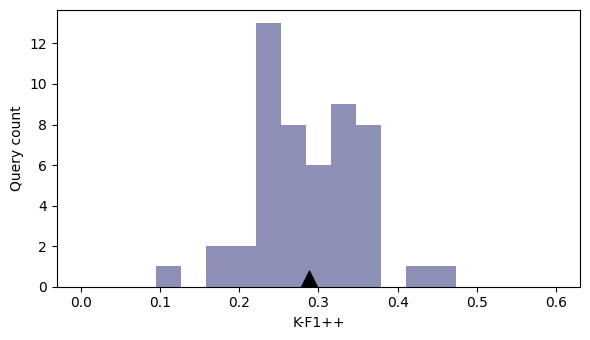

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(slide_fig_width_in, slide_fig_height_in))

xs_low = autometric_df[autometric_df.guidance == "low"].f1
xs_high = autometric_df[autometric_df.guidance == "high"].f1
bins = np.linspace(0, 0.6, num=20)
ax.hist(xs_low, bins=bins, log=False, alpha=0.6, color=matplotlib.cm.viridis(0.2), label="Prompt 1")
# ax.hist(xs_high, bins=bins, log=False, alpha=0.4, color=matplotlib.cm.viridis(0.4), label="Prompt 2")
ax.scatter(xs_low.mean(), 0, color="black", marker="^", s=550)
# ax.scatter(xs_high.mean(), 0, color="black", marker="^", s=550)
# ax.legend()
ax.set_ylabel("Query count")
ax.set_xlabel("K-F1++")

fig.tight_layout()
fig.savefig(figures_dir / "slides_kf1_hist_low.png", pad_inches=0.1, dpi=slide_fig_dpi)
plt.show()

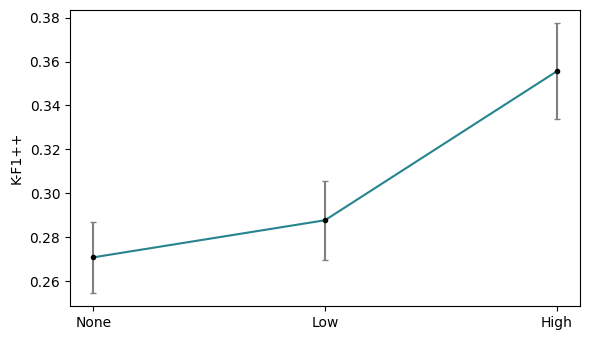

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(slide_fig_width_in, slide_fig_height_in))

metric_pretty_name_map = {
    "macro_f1": "K-F1++",
    "bleurt": "BLEURT",
    "bertscore": "BERTScore",
}

guidance_short_name_map = {
    "none": "None",
    "extract_relevant": "IR",
    "low": "Low",
    "medium": "M",
    "high": "High",
}

metric = "macro_f1"
for query_set, mdf in metric_df.groupby("query_set"):
    assert metric in mdf.columns
    mdf = mdf[mdf.guidance != "extract_relevant"]
    xs = list(range(len(mdf)))
    ys = mdf[metric]
    yerr = mdf[[metric + "_low", metric + "_high"]].subtract(mdf[metric], axis=0).abs().T
    ax.scatter(xs, ys, color="black", marker=".")
    ax.errorbar(
        xs, ys, yerr=yerr, zorder=-1, capsize=2, ecolor="gray", color=matplotlib.cm.viridis(0.45), label=query_set
    )

ax.set_xticks(xs, labels=[guidance_short_name_map[guidance] for guidance in mdf.guidance])
ax.set_ylabel(metric_pretty_name_map[metric])

fig.tight_layout()
fig.savefig(figures_dir / "slides_kf1_no_ir.png", pad_inches=0.1, dpi=slide_fig_dpi)
plt.show()

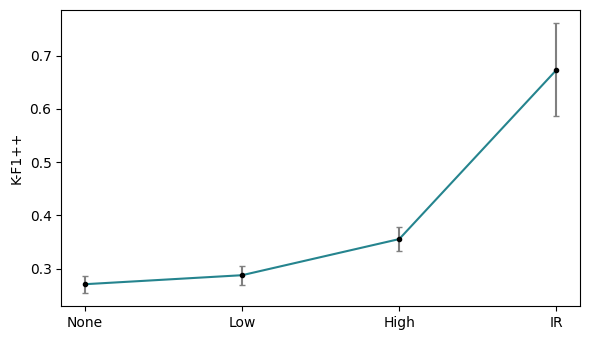

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(slide_fig_width_in, slide_fig_height_in))

metric_pretty_name_map = {
    "macro_f1": "K-F1++",
    "bleurt": "BLEURT",
    "bertscore": "BERTScore",
}

guidance_short_name_map = {
    "none": "None",
    "extract_relevant": "IR",
    "low": "Low",
    "medium": "M",
    "high": "High",
}

metric = "macro_f1"
for query_set, mdf in metric_df.groupby("query_set"):
    assert metric in mdf.columns
    # mdf = mdf[mdf.guidance != "extract_relevant"]
    xs = list(range(len(mdf)))
    ys = mdf[metric]
    yerr = mdf[[metric + "_low", metric + "_high"]].subtract(mdf[metric], axis=0).abs().T
    ax.scatter(xs, ys, color="black", marker=".")
    ax.errorbar(
        xs, ys, yerr=yerr, zorder=-1, capsize=2, ecolor="gray", color=matplotlib.cm.viridis(0.45), label=query_set
    )

ax.set_xticks(xs, labels=[guidance_short_name_map[guidance] for guidance in mdf.guidance])
ax.set_ylabel(metric_pretty_name_map[metric])

fig.tight_layout()
fig.savefig(figures_dir / "slides_kf1.png", pad_inches=0.1, dpi=slide_fig_dpi)
plt.show()